### Daily Observations

### Summary of notebook: 
- Due to low amount of patients tested negative for Ebola, the daily observation dataset will be used for prognosis and not diagnosis. That is to "predict" the outcome of the patient knowing the positive Ebola status
We reckon the cause for the low Ebola negative patients is because, once they are in Macenta and get the test (Line list dataset) they are more likely to be sent to Guéckédou, a nearby bigger city with a clinic.
- We merged the important and useful information between the two datasets, that is we added "outcome", "epistat" (Ebola Status),"datclin" (date at the clinic), "age", "sex" from Line list to clinical.
- Not all patients from Line list were found at the clinic. Indeed at the clinic we have 769 unique patients that matched with line list compared to the 2500 patients at Macenta.
- We replaced the missing values of age by the median for patients that did not have it, many patients had missing values for temperature (marked by 99). We did verify whether it might be given in Farhenheit but there was no distribution around 99. Just 99.

We then looked at the distribution of patients at the clinic, for this :
- Since the observations are daily, we take the number of unique "datclin" grouped by identifier ('msfid') and renamed the columm to Time_stayed. We also add a feature corresponding to the first date. 
- Histogram of distribution for patients, we see most patients stayed either 3 or 5 days. We decide to pick a time frame of 5 days, this would result in less patients but more "continous" data.
- New dataframe with patients that stayed 5 days or longer (keep first five days)

Daily observation fusion 
- We noticed that the same patient has a different number of observations per day. We also noted that some symptoms are not "looked at" or "asked" when the doctor comes in several times a day. This means at 8 am one asks if you have backpain, but at 12 not. We therefore decide to group the features by day with the following assumptions:
--- if you are positive at least once during the day, you are considered positive during the whole day
--- if you are all unknown you remain unknown
--- if you are negative and unknwon, you are considered negative
We had to be very careful as not all features are given by, yes, no, unknown. The details are explain under "Fuse the observations that were taken on same day"

We note several features with too many missing values, we are careful to verify that these are not features that may be taken only once every 3 days or so (such as a test).

"df" is a dataframe whith the observations within a day combined. 
- We then drop "epistat" (Ebola status) because we kept only positive patients and thus this feature does not bring more information
- We then drop columns that only have unknwons --> (None)

*We had to do pre-processing at different steps of building up our final dataframe*
Now that the days are combined we can look at symptoms with many missing values (distribution further down)
we separate the features by different categories 
- symptoms: We look at symptoms which do not bring extra information, we must carefully choose symptoms that bring same information(examples are given in the notebook)
- treatments: treatments given at the clinic
- "other sicknesses" : such as malaria, hiv ... (We needed to make sure that at least a significant amount of different patients had recieved the tests) --> This was not the case.
- We set a threshold of 20 % for missing values, that is all features with more than 20 % missing values are discarded

*Now we have a semi-cleaned dataframe for daily observations for patients that stayed five days or longer (take only first five days)*
We merge the cleaned "group" of dataframes together 

*Now we will take the first day of each patient, and concatenate it with the other days*
This means we get less rows and more columns. We hope for the model to pick up on this time continious data. "The patient's evolution"

Feature selection: 
Now we proceed to some more data cleaning. We can now be more strict on the amount of missing values per column we permit. 
We also only now can remove lines (thus patients and not observations) whom have too many missing values
We remove features we don't need anymore.

One hot encoding for sex:
- For patients that were F, M or U (Unknown)

Replace missing values (NaN's) by zero

*Data visalization*
- The interesting correlation matrix which will be discussed in report
- Imbalance with more survival than deaths

*Split data*
- We split in a statrified manner between train and test in order to keep the same ratios. Even though this does represent a "significant" number of deaths, we imagine the data being true in the case of a major epidemic such as Ebola. 

*Normalizing the data*
- We normalize continious data such as age and dates (converted to represent the number of days starting from the given year)
- Remember to normalize your training data and then apply the mean and the standard deviation received to apply on test set 

*Processing*
- We remove features with zero standard deviation, that is features that hold the same values for all and thus do not bring additional information
- We remove highly correlated features (> 75), we remove one of them if it's two, two if it's three ...

*Feature selection*
- We will use SelectKBest in order to retrieve the k highest scoring features. We also also f_classif which calculates the anova F-value between the label (outcome) and the features. It estimates the dergee of linear dependency between two random variables.
- The best k is then used for each model when tuning the hyper-parameters 

In [262]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For pre-processing
import datetime
from sklearn.preprocessing import StandardScaler
from yellowbrick.features import Manifold

# For the models
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

from yellowbrick.model_selection import ValidationCurve
from sklearn.svm import SVC
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
# Importing our functions
from proj2_HELPERS_ import *

In [3]:
# Path to dataset (change)

df_line = pd.read_csv('../../Original dataset/EGOYQN_Gueckedou_linelist_cleaned_pos_and_neg_2019_November_ANSI.csv', encoding = 'ISO-8859-1')
df_line.head()

,msfid,mcid,datmac,transit,admis,gkdid,datgck,age,sex,respref,...,pcr2ct,epistat,commun,currstat,exdat,outold,outcome,locdec,condat,source
0,G1,Absent,01/01/1900,Non,Non,Absent,01/01/1900,60.0,2,14,...,.,2,1,1,2/22/2014,3,2,GUECKEDOU,02/02/2014,.
1,G10,Absent,01/01/1900,Non,Non,Absent,01/01/1900,35.0,2,14,...,.,1,0,1,3/17/2014,1,2,Hosto GKD,2/25/2014,.
2,G100,Absent,01/01/1900,Non,Oui,GKD25,04/11/2014,40.0,1,14,...,.,1,0,2,4/20/2014,8,1,na,01/01/1900,.
3,G1000,MC260,9/17/2014,Non,Oui,GKD775,01/01/1900,40.0,1,25,...,.,1,0,1,9/19/2014,3,2,Non rempli,01/01/1900,.
4,G1001,Absent,9/17/2014,Non,Oui,GKD776,9/19/2014,8.0,2,25,...,.,1,0,1,9/21/2014,3,2,Non rempli,01/01/1900,.


In [4]:
df_clinical = pd.read_csv('../../Original dataset/EGOYQN_Gueckedou_clinFU_cleaned_pos_and_neg_2019_November.csv', encoding = 'ISO-8859-1')
df_clinical.head()

/home/lavinia/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (58,59) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,msfid,datclin,timclin,unid,ceph,asthen,myalc,arthralc,fevr,oedc,...,mningit,encphal,erysip,cardio,fessier,epilep,mendis,otherco,notesread,dup
0,G100,4/14/2014,16,G100_14apr2014_16,0,0,0,0,.,0,...,.,.,.,.,.,.,.,.,.,0
1,G100,4/14/2014,12,G100_14apr2014_12,0,0,0,0,.,0,...,.,.,.,.,.,.,.,.,.,0
2,G100,4/16/2014,9,G100_16apr2014_9,0,0,0,0,.,0,...,.,.,.,.,.,.,.,.,.,0
3,G100,4/15/2014,12,G100_15apr2014_12,0,0,0,0,.,0,...,.,.,.,.,.,.,.,.,.,0
4,G100,4/15/2014,16,G100_15apr2014_16,0,0,0,0,.,0,...,.,.,.,.,.,.,.,.,.,0


### Ebola tested patients in Linelist

We apply dictionary to ebola data
where 1 is positive, 0 is negative and -1 unknown
Important: 2 is probable and we decided to put it in the positive category
3 and 9 are unknwon 

In [5]:
df_line['epistat'].value_counts(dropna=False)

1    1372
0     978
2     135
3      13
9       2
Name: epistat, dtype: int64

In [6]:
dict_ebola_answer = {0:0, 1:1, 2:1, 3:-1, 9:-1, '.':-1}
df_line['epistat'] = df_line['epistat'].apply(lambda x : dict_ebola_answer[x])

#### To the Clinical data we add the "epistat" (positive/negative to Ebola) feature from the linelist datafile, the "datsym" representing the estimated start of symptoms and the "outcome" (Death/survival), the age and the sex of the patients


#### "Creation of new feature"

We create a new feature name "dt" which takes the difference of time between the appearance of the first symptoms and the admittance to the clinic. 

In [7]:
# Joining the data_sets 
df_clinical= df_clinical.join(df_line.set_index('msfid')[['datsym', 'epistat', 'outcome', 'age', 'sex']], on='msfid')


df_clinical.datclin = pd.to_datetime(df_clinical.datclin)
df_clinical.datsym = pd.to_datetime(df_clinical.datsym)

# Create feature with difference in dates between start of symptoms and start at the clinic
df_clinical['dt'] = (df_clinical.datclin - df_clinical.datsym).dt.days

In [8]:
# Let's have a look at people whose symptoms appears before their admittance

# df_clinical[df_clinical['dt'] < 0]['dt'].value_counts()

# We remove obersvation with absurd values, here set at a difference of over 40 thousand days
# removed 34 observations
df_clinical = df_clinical[df_clinical['dt'] > -40000]

In [9]:
df_clinical['msfid'].nunique()

769

769 patients remain 

#### Let us now analyse the Ebola final status feature 'epistat'


In [10]:
# Ebola positive samples
df_clinical[df_clinical['epistat'] == 1].count()

msfid      13423
datclin    13423
timclin    13423
unid       13423
ceph       13423
           ...  
epistat    13423
outcome    13423
age        13423
sex        13423
dt         13423
Length: 119, dtype: int64

In [11]:
# Number of unique patients who are negative to Ebola
df_clinical[df_clinical['epistat'] == 0].nunique()

msfid       12
datclin     35
timclin     18
unid       130
ceph         2
          ... 
epistat      1
outcome      2
age         12
sex          3
dt          17
Length: 119, dtype: int64

*We only have 12 unique patients in Clinical that at some point compared to 769 patients*

#### We will therefore only look at prognosis and not diagnosis, let us drop the patients that are ebola negative

In [12]:
# Drop Ebola negative patients
df_clinical = df_clinical[df_clinical['epistat'] != 0]

In [13]:
# Sanity check
df_clinical['epistat'].value_counts(dropna = False)

1.0    13423
Name: epistat, dtype: int64

In [14]:
df_clinical['msfid'].nunique()

757

*__We have now 757* patients who are ebola positive on whom we wish to establish a model to predict their outcome__*

### Age

In [15]:
# Unknwon ages
(df_clinical['age']== 999).sum()

138

In [16]:
df_clinical['age'].replace(999, np.nan, inplace = True)

In [17]:
# Remplace the nan values by the median age
df_clinical['age'].fillna(df_line['age'].median(),inplace = True)

##### We replace the few missing data for the age by the median 

### Sex

In [18]:
df_sex = df_clinical['sex']

dict_sex = {1: 1 ,2:0, 9: -1}
df_sex = df_sex.apply(lambda x : dict_sex[x])

### Fever temperature

In [19]:
sum(df_clinical['fevtemp'].isna())

0

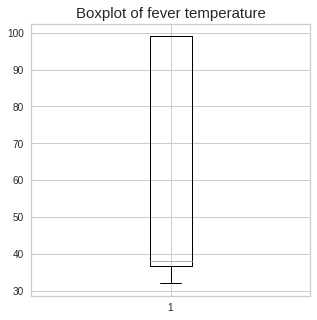

In [20]:
fig, ax = plt.subplots(figsize=(5,5))

ax.set_title("Boxplot of fever temperature",size=15)
plt.boxplot(df_clinical['fevtemp'])
plt.show()

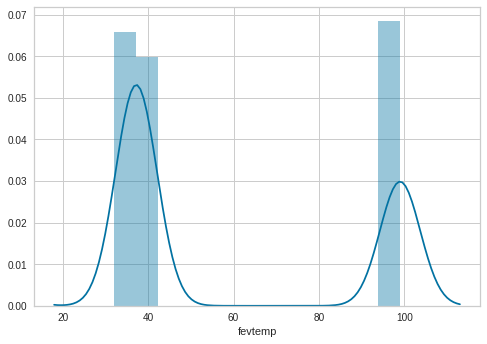

In [21]:
sns.distplot(df_clinical["fevtemp"])
plt.show()

We see a peak at 99, these will be missing values.
We thought they might be given in fareinheit but the value counts tells us different (since only 99's and no "ditribution") If we had a distribtion around 99 we could expect different units

## Distribution of time spent at the clinic

We are interested into looking at the possible evolution of the patients at the clinic for a few days in a row to see how the symptoms and other features will influence the outcome. Knowing the likely causes and symptoms that make you more prone to decease would increase the chance of making good decisions for the nurses and doctors, in order to increase your chances to survive.

### First day of patient at the clinic

In [22]:

# this is calculated by looking at the minimum date for each patient
df_min = pd.DataFrame(df_clinical.groupby(by = 'msfid').datclin.min()).reset_index().rename(columns={'datclin':'first_date'})

df_min.head()

,msfid,first_date
0,G100,2014-04-11
1,G1000,2014-09-17
2,G1001,2014-09-17
3,G1002,2014-09-17
4,G1004,2014-09-18


In [23]:
# Merge with original data frame
df_mer_date = df_clinical.merge(df_min, on = 'msfid', how = 'left')

In [24]:
# Time stayed at the clinic. 
# We look at unique dates since the observations are daily, every day the patients go to the clinic

df_stay = pd.DataFrame(df_clinical.groupby(by = 'msfid').datclin.nunique()).reset_index().rename(columns={'datclin':'Time_stayed'})

df_stay.head()

,msfid,Time_stayed
0,G100,10
1,G1000,2
2,G1001,3
3,G1002,18
4,G1004,3


Text(0.5, 0, 'Number of patients')

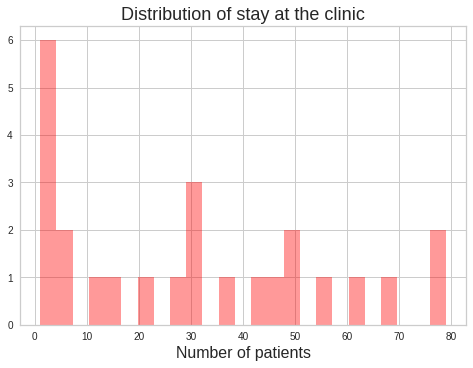

In [25]:
sns.distplot(df_stay['Time_stayed'].value_counts(), kde=False, color='red', bins=25)
plt.title('Distribution of stay at the clinic', fontsize=18)
plt.xlabel('Number of patients', fontsize=16)


In [26]:
df_stay['Time_stayed'].value_counts().sort_values(ascending = False)

3     79
5     79
2     68
4     63
7     56
8     49
9     49
6     45
10    42
11    37
12    30
13    30
15    30
1     29
14    20
17    15
16    12
19     6
18     5
21     4
20     3
24     2
22     2
23     1
25     1
Name: Time_stayed, dtype: int64

## *The results above, allow us to decide we'll take patients that have stayed at least 5 days, this will enable us to keep as much continious data as possible in this dataset* 
We decided to keep 5 instead of 3, this would indeed yield to less patients, but we would get a better reprsentation of delevopments (of symptoms) over time

In [27]:
# How many patients stayed 5 or more days
tot_patients = (df_stay['Time_stayed']> 4).sum()
(df_stay['Time_stayed']> 4).sum()

518

In [28]:
df_stay['Time_stayed'].value_counts().sum()

757

We keep 518 patients out of 757 !

In [29]:
# We keep the frames of people staying 5 days or more
df_selected = df_stay[(df_stay['Time_stayed']> 4)] 
df_selected.head()

,msfid,Time_stayed
0,G100,10
3,G1002,18
5,G1005,7
6,G1006,9
7,G1007,8


In [30]:
df_selected_ml = df_mer_date.merge(df_selected, on = 'msfid', how = 'inner')
df_selected_ml

,msfid,datclin,timclin,unid,ceph,asthen,myalc,arthralc,fevr,oedc,...,notesread,dup,datsym,epistat,outcome,age,sex,dt,first_date,Time_stayed
0,G100,2014-04-14,16,G100_14apr2014_16,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,5.0,2014-04-11,10
1,G100,2014-04-14,12,G100_14apr2014_12,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,5.0,2014-04-11,10
2,G100,2014-04-16,9,G100_16apr2014_9,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,7.0,2014-04-11,10
3,G100,2014-04-15,12,G100_15apr2014_12,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,6.0,2014-04-11,10
4,G100,2014-04-15,16,G100_15apr2014_16,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,6.0,2014-04-11,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12048,G2493,2015-01-14,17,G2493_14jan2015_17,0,0,0,0,0,0,...,Yes,0,2015-01-01,1.0,1,20.0,1.0,13.0,2015-01-10,9
12049,G2493,2015-01-15,6,G2493_15jan2015_6,0,0,0,0,0,0,...,Yes,0,2015-01-01,1.0,1,20.0,1.0,14.0,2015-01-10,9
12050,G2493,2015-01-13,9,G2493_13jan2015_9,0,0,0,0,0,0,...,Yes,0,2015-01-01,1.0,1,20.0,1.0,12.0,2015-01-10,9
12051,G2493,2015-01-13,17,G2493_13jan2015_17,0,0,0,0,0,0,...,Yes,0,2015-01-01,1.0,1,20.0,1.0,12.0,2015-01-10,9


Now that we have the dataframe of the patients who stay for more than 5 days, we should take the five first days for the patients. In order to make a "symmetric" dataframe. Otherwise when contcatenating on the days spent at the clinic, those who stayed more than five would have more columns but not the ones that stayed exactly five days.

Taking the first five days for a patient that stayed longer might/will cause some bias in the model as that patient may feel better the first five days and then have their health state diminish (possibly explained the extended time at the clinic)

In [31]:

# strictly inferior to 5 because we start at 0 :) 
df_5_days = df_selected_ml[df_selected_ml['datclin']- df_selected_ml['first_date'] < '5 days']

# Daily observations fusion 

In order to get the most possible information out of the data set, we will fuse the days with one another. We make the following assumptions:
- If the patient has a symptom at some hour of the day, the patient will be positive for that symptom during the whole day
- For the temperature we take the mean within the day

It is possible the doctors make specific tests at specific hours and being negative at one hour in all symptoms but not the following would yield into removing that observation, but this may just be because of specific tests at sepcific times.



# Fuse the observations that were taken on the same day

Each "group" of features must be handled differently


In [32]:
# The following home-made function enables us to separate the dataframe depending on the "category" of the feature. Whether it has number, dates etc as they will be handled differently
list_of_symptoms=[]
for i, name in enumerate(df_5_days.columns):
    if all(str(x) in ['0', '1', '2', '3', '8', '9', "."] for x in list(df_5_days[name].value_counts().index)):
        if name != 'outcome':  # We don't take the 'outcome' because this will be our target labels so they will be added to the final dataframe later
            list_of_symptoms.append(name)

list_of_constants = []
for i, name in enumerate(df_5_days.columns):
    grouped = df_5_days.groupby(by= ['msfid', 'datclin']).nunique()
    if name not in ['msfid', 'datclin', 'outcome']: # outcome is for later
        if grouped[name].sum() == len(grouped[name]): # if the sum on the column = its lenght => it had only 1's => only 1 unique element per day
            list_of_constants.append(name)

In [33]:
print(list_of_symptoms)
print(list_of_constants)

['ceph', 'asthen', 'myalc', 'arthralc', 'fevr', 'oedc', 'chocc', 'anurc', 'convc', 'swallow', 'hiccups', 'anorc', 'nausc', 'vomit', 'abdopain', 'abdosens', 'doulqs', 'diarrc', 'gastro', 'cough', 'dyspc', 'resp', 'chestpain', 'vertpain', 'lombar', 'ictc', 'pruri', 'hepmeg', 'splenmeg', 'erupcut', 'deshyd', 'photoc', 'occulair', 'tremb', 'friss', 'vert', 'amenn', 'pros', 'desor', 'agitc', 'injconj', 'epista', 'gum', 'hemopty', 'hematem', 'stool', 'hemat', 'vagbl', 'injbl', 'petc', 'parat', 'coartt', 'artest', 'ppnt', 'orst', 'paracett', 'ciprot', 'cefixt', 'ceftriaxt', 'multivitt', 'metaclot', 'omept', 'diazt', 'tramadt', 'ctrz', 'cta', 'metro', 'amox', 'prometh', 'amoclav', 'genta', 'ampi', 'albend', 'azithro', 'chlor', 'morph', 'tetra', 'fluco', 'mysta', 'busco', 'miso', 'zinc', 'ivcare', 'rlt', 'rltg', 'rltk', 'gluc', 'perfal', 'malari', 'hivpos', 'mningit', 'encphal', 'erysip', 'cardio', 'fessier', 'epilep', 'mendis', 'dup']
['datsym', 'epistat', 'age', 'sex', 'dt', 'first_date', 'Ti

In [34]:
# Sanity check : we don't want an overlap of the lists
print(set(list_of_symptoms) & set(list_of_constants))

set()


In [35]:
def merger_for_const(df, list_of_constants): # fuse entries accross the day for when they are the same
    df_cut = df[['msfid', 'datclin'] + list_of_constants].copy() 
    df_fusion = df_cut.groupby(by= ['msfid', 'datclin']).head(1) # just assign the first entry of the day
    return df_fusion.set_index(['msfid', 'datclin']) # Need to specify index (.head() does not automaticlly keed the same group structure as the other methods of the class)

In [36]:
# Make a small dictionnary to reformat the symptoms 
dict_read_symptoms = {0  : 1,1  : 100, '0': 1, '1': 100, '9': 0, 9  : 0, 8  : 0, '8': 0, '.': 0 }



When merging for one day, the assumption states that if you were positive at one point in the day you will be for all the day, this means we should take the sum, but since the patient may have nan values we therefore cannot perform that summation (within a day directly). 
Options :
- Replacing the nans by zero --> Not good because then we loose the information between who is negative and who is unknwon
We used a small trick: 
Since we know the patients don't have more than 100 observations per day, we do the following
- Unknowns are change to zeros
- Negatives to 1 
- Postives to 100

Then, by summing, if you:
- only have zeros, yu are changed to nan
- are below 100, you have been test at least once negative (but no positives)
- Above 100, you must have tested at least positive once during that time 

In [37]:
def merger_for_symptoms(df, list_of_symptoms, dict_read_symptoms): # Since you can either manifest the symptom or not, just make the sum accross the entries of the day
    # Note that this method assumes that if a symptom is present at some point of the day, the patient still has it at the end of that day
    df_cut = df[['msfid', 'datclin'] + list_of_symptoms].copy()
    df_cut[list_of_symptoms] = df_cut[list_of_symptoms].applymap(lambda x: dict_read_symptoms[x]) # use the dict. to reformat
    df_fusion = df_cut.groupby(by= ['msfid', 'datclin']).sum()
    df_fusion[df_fusion[list_of_symptoms] == 0] = np.nan # in this context, we want that 1 + 1 = 1 
    df_fusion[df_fusion[list_of_symptoms] < 99] = 0 # in this context, we want that 1 + 1 = 1 
    df_fusion[df_fusion[list_of_symptoms] > 99] = 1 # in this context, we want that 1 + 1 = 1 
    return df_fusion

In [38]:
rest = list(set(df_5_days.columns) - set(list_of_constants) - set(list_of_symptoms))
print(rest)

['conscc', 'fevtemp', 'msfid', 'otherco', 'bp', 'rrate', 'datclin', 'notesread', 'othrhe', 'outcome', 'othrtx', 'othrsym', 'pouls', 'unid', 'deshcat', 'timclin']


### Functions to treat all the odd columns, printed above
(except of course 'msfid', 'datclin','timclin'and also 'outcome')

where:
- msfid: id of the patient
- datclin: Date of observation
- timclin: Time of observation
- outcome: Survival/Death 

In [39]:
# 'otherco'
df_5_days['otherco'].value_counts()

.         4211
ABSENT     910
na         220
NR           4
absent       2
Name: otherco, dtype: int64

 #### Missing too many, drop the column.

In [40]:
# 'notesread'
df_5_days['notesread'].value_counts()

Yes    4059
.      1461
No      429
Name: notesread, dtype: int64

Just says wether the notes were readable or not; not relevant here :
#### will not be kept

In [41]:
# Other treatment
df_5_days['othrtx'].value_counts()

.                          3338
ABSENT                     1038
na                          256
FAVIPIRAVIR                 212
ONDANSETRON                  89
                           ... 
Myoscin butylbranide          1
FAIVPIRAVIR                   1
VITAMIN A, FAVIPIRAVIR        1
FAVIPIRAVIR, ODANSATRON       1
eau (water)                   1
Name: othrtx, Length: 90, dtype: int64

#### Will not be kept

#### Pouls

In [42]:
df_5_days['pouls'] = df_5_days['pouls'].astype('int')

<ipython-input-42-954a8217f250>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5_days['pouls'] = df_5_days['pouls'].astype('int')


In [43]:
# Total number of unique patients
tot_patients

518

In [44]:
df_5_days['pouls'] == 999

0        True
1        True
3        True
4        True
5        True
         ... 
12047    True
12048    True
12050    True
12051    True
12052    True
Name: pouls, Length: 5949, dtype: bool

In [45]:
# Missing value in pouls
missing_pouls = df_5_days[df_5_days['pouls'] == 999]['msfid'].count()
missing_pouls

5686

In [46]:
# Total number of observations
total_obvs = df_5_days['msfid'].count()
total_obvs

5949

In [47]:
ratio_pouls = missing_pouls / total_obvs
ratio_pouls

0.9557908892250798

####  We have a lot of missing values of the heartbeat, it's not taken at each observations. Let see if we have at least one heartbeat for each patient.

In [48]:
# Unique patients who've had their pouls measured
pouls_pat = len(df_5_days[df_5_days['pouls'] != 999].groupby('msfid').pouls.count())
pouls_pat

60

In [49]:
# Number of observations (per day) were pulse 
pouls_obs = sum(df_5_days[df_5_days['pouls'] != 999.0].groupby('msfid').pouls.count()) 

In [50]:
pouls_pat/tot_patients

0.11583011583011583

In [51]:
pouls_obs /total_obvs

0.04420911077492015

##### We only have the heartbeat for 60 unique patients, that is 11% of the cohort and only for 4.4% of the observations. 

Not enough... we drop

#### Blood pressure

In [52]:
df_5_days['bp'].value_counts(dropna = False).head()

999    3010
999    2319
100     131
80      107
90       99
Name: bp, dtype: int64

In [53]:

df_5_days['bp'].fillna(999.0, inplace = True)
df_5_days['bp'].replace('.',999, inplace = True)
# We note some values are in strings, let's make them int since we have no floats
df_5_days['bp'] = df_5_days['bp'].astype('int')

/home/lavinia/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/home/lavinia/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
<ipython-input-53-8e8b0ab52b42>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [54]:
df_5_days[df_5_days['bp'] != 999.0].groupby('msfid').bp.count().head()

msfid
G1005    2
G1006    3
G1007    1
G1008    2
G1009    1
Name: bp, dtype: int64

In [55]:
# NUmber of observations that are not unknown
bp_obs = sum(df_5_days[df_5_days['bp'] != 999.0].groupby('msfid').bp.count())
bp_obs

620

In [56]:
# Number of patients who got their blood pressure measured at least once
bp_pat = len(df_5_days[df_5_days['bp'] != 999.0].groupby('msfid').bp.count())
bp_pat

209

In [57]:
bp_pat/tot_patients

0.4034749034749035

In [58]:
bp_obs/total_obvs

0.10421919650361405

#### We have the bloodpressure for 209 patients, that is 40% of the cohort and 10 % of the observations. 

In [59]:
f = {'bp': ['count','mean', 'median', 'std', 'skew', pd.DataFrame.kurt, lambda x : x.quantile(0.25), lambda x : x.quantile(0.75)]}
df_5_days.loc[:,['msfid','bp']].groupby('msfid').agg(f).fillna(0).rename(columns={"<lambda_0>": "first quartile", "<lambda_1>": "third quartile "}).head()

bp                                                                    \
      count        mean median         std      skew      kurt first quartile   
msfid                                                                           
G100     15  999.000000  999.0    0.000000  0.000000  0.000000         999.00   
G1002    12  999.000000  999.0    0.000000  0.000000  0.000000         999.00   
G1005     6  697.666667  999.0  466.834303 -0.968446 -1.873796         324.75   
G1006     8  661.875000  999.0  465.368805 -0.645579 -2.233894         112.50   
G1007     9  889.111111  999.0  329.666667 -3.000000  9.000000         999.00   

                       
      third quartile   
msfid                  
G100            999.0  
G1002           999.0  
G1005           999.0  
G1006           999.0  
G1007           999.0

#### We will this drop this feature as well. 

#### Respiration Rate

In [60]:
df_5_days['rrate'].value_counts(dropna = False).head()


999    3238
999    2435
24       32
20       31
28       28
Name: rrate, dtype: int64

In [61]:
df_5_days['rrate'].fillna(999.0, inplace = True)
df_5_days['rrate'].replace('.',999, inplace = True)
# We note some values are in strings, let's make them int since we have no floats
df_5_days['rrate'] = df_5_days['rrate'].astype('int')


/home/lavinia/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/home/lavinia/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
<ipython-input-61-088cc6fb5554>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [62]:
# Number of observations for respiration rate
rrate_obs = sum(df_5_days[df_5_days['rrate'] != 999.0].groupby('msfid').rrate.count())
rrate_obs

276

In [63]:
rrate_obs/total_obvs

0.04639435199193142

In [64]:
patients_rrate = len(df_5_days[df_5_days['rrate'] != 999.0].groupby('msfid').rrate.count())
print(patients_rrate)
ratio_rrate = patients_rrate / tot_patients
ratio_rrate

59


0.1138996138996139

##### We have the respiration rate for 59 patients, that is 11% of the cohort and 4.6% of the observations. 

### Other categorical symptoms

In [65]:
df_5_days['deshcat'].value_counts().head()

Non rempli                                4542
Pas applicable (non inclus dans fiche)    1394
B: irritable and restless, sunke             6
C: floppy baby/lethargic or unco             4
A: alert, eyes normal, not thirs             3
Name: deshcat, dtype: int64

In [66]:
dict_deshcat = {'Non rempli' : 'Unknown', 'Pas applicable (non inclus dans fiche)' : 'Unknown', \
               'A: alert, eyes normal, not thirs' : 'Alert', 'B: irritable and restless, sunke' : 'Irritable', \
               'C: floppy baby/lethargic or unco' : 'Lethargic', '.' : 'Unknown'}

df_5_days['deshcat'] = df_5_days['deshcat'].apply(lambda x: dict_deshcat[x])

<ipython-input-66-cb70091260e9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5_days['deshcat'] = df_5_days['deshcat'].apply(lambda x: dict_deshcat[x])


In [67]:
# deshcat () different than unknown

df_5_days.loc[df_5_days['deshcat'] != 'Unknown'].groupby('msfid').deshcat.count()

msfid
G1570    1
G1624    1
G1804    3
G1903    1
G1934    2
G2078    1
G2102    1
G645     1
G647     1
G788     1
Name: deshcat, dtype: int64

#### Too few values, we'll drop this feature.

### Consciousness feature 'conscc'

The Glasgow Coma Scale (GCS) is used to objectively describe the extent of impaired **consciousness** in all types of acute medical and trauma patients. The scale assesses patients according to three aspects of responsiveness: eye-opening, motor, and verbal responses. Reporting each of these separately provides a clear, communicable picture of a patient’s state.
More in https://www.ncbi.nlm.nih.gov/books/NBK513298/#:~:text=%5B1%5D%20The%20Glasgow%20Coma%20Scale,%2C%20motor%2C%20and%20verbal%20responses.

In [68]:
df_5_days['conscc'].value_counts()

Non rempli                         4011
Pas applicable (non inclus dans    1640
Alert GCS=13,14,15                  231
Voice GCS=9,10,11,12                 36
Pain GCS=4,5,6,7,8                   16
Unresponsive GCS=1,2,3               15
Name: conscc, dtype: int64

In [69]:
dict_conscc = {'Non rempli' : 'Unknown', 'Pas applicable (non inclus dans' : 'Unknown', \
               'Alert GCS=13,14,15' : 'Alert: GCS in [13,15]', 'Unresponsive GCS=1,2,3' : 'Unresponsive: GCS in [1,3]', \
               'Pain GCS=4,5,6,7,8' : 'Pain GCS in [4,8]', 'Voice GCS=9,10,11,12' : 'Voice: GCS in [9,12]', \
               '.' : 'Unknown'}

df_5_days['conscc'] = df_5_days['conscc'].apply(lambda x: dict_conscc[x])

<ipython-input-69-e189f43c71cf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5_days['conscc'] = df_5_days['conscc'].apply(lambda x: dict_conscc[x])


In [70]:
df_cons = df_5_days.loc[(df_5_days['conscc'] != 'Unknown'),['conscc','msfid']].groupby(by = 'msfid').count()

In [71]:
# we have 162 patients with this feature not unknown
(df_cons != 0).sum()

conscc    162
dtype: int64

In [72]:
df_5_days['unid'].value_counts().head()

G1579_31oct2014_9     3
G1579_29oct2014_9     3
G296_30may2014_10     3
G1579_01nov2014_16    2
G112_17apr2014_16     2
Name: unid, dtype: int64

### Functions that will merge all the results of a day together 

In [73]:

def merger_for_weird(df, name_of_column): # just take the first non-null entry of the day (and hope it's the only one)
    df_cut = df[['msfid', 'datclin', name_of_column]].copy()
    df_cut[df_cut[name_of_column] == '.'] = np.nan
    df_cut[df_cut[name_of_column] == 'na'] = np.nan
    df_cut[df_cut[name_of_column] == 'ABSENT'] = np.nan
    df_cut[df_cut[name_of_column] == 'Non rempli'] = np.nan
    df_cut[df_cut[name_of_column] == 'Unknown'] = np.nan
    df_cut[df_cut[name_of_column] == 'Pas applicable (non inclus dans'] = np.nan
    df_fusion = df_cut.groupby(by=['msfid', 'datclin']).nth(0, dropna='any') # take the first (array start at 0) non-null element of the group
    return df_fusion

In [74]:
def merger_for_means(df, name_of_column): # will take the mean of entries accros the day
    df_cut = df[['msfid', 'datclin', name_of_column]].copy()
    df_cut[name_of_column] = df_cut[name_of_column].astype(float) # some values are '1' instead of 1 , '100' instead of 100 , etc.
    df_cut[df_cut[name_of_column]== 999] = np.nan
    if name_of_column == 'fevtemp': # for some funky reason the missing values in fevtemp are noted with a 99 instead of 999
        df_cut[df_cut[name_of_column] == 99] = np.nan
    df_fusion = df_cut.groupby(by=['msfid', 'datclin']).mean()
    return df_fusion

## Now make a single function to do it all

In [75]:
def merge_same_day_observations(df, list_of_symptoms, dict_read_symptoms, list_of_constants):
    # separately make the fusion corresponding to the correct operation
    df_symptoms_fused  = merger_for_symptoms(df, list_of_symptoms, dict_read_symptoms)
    df_constants_fused = merger_for_const(df, list_of_constants)
    df_fevtemp_fused   = merger_for_means(df, 'fevtemp')
    df_conscc_fused     = merger_for_weird(df, 'conscc')
    
    # Now join them all together
    df_all = df_symptoms_fused.join([
        df_constants_fused,
        df_fevtemp_fused,
        df_conscc_fused])
    return df_all.reset_index()

In [76]:
df = merge_same_day_observations(df_5_days, list_of_symptoms, dict_read_symptoms, list_of_constants)

In [77]:
df.head()

,msfid,datclin,ceph,asthen,myalc,arthralc,fevr,oedc,chocc,anurc,...,dup,datsym,epistat,age,sex,dt,first_date,Time_stayed,fevtemp,conscc
0,G100,2014-04-11,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0,2014-04-09,1.0,40.0,1.0,2.0,2014-04-11,10,38.300000,NaN
1,G100,2014-04-12,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0,2014-04-09,1.0,40.0,1.0,3.0,2014-04-11,10,37.400000,NaN
2,G100,2014-04-13,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0,2014-04-09,1.0,40.0,1.0,4.0,2014-04-11,10,37.150000,NaN
3,G100,2014-04-14,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0,2014-04-09,1.0,40.0,1.0,5.0,2014-04-11,10,37.650000,NaN
4,G100,2014-04-15,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0,2014-04-09,1.0,40.0,1.0,6.0,2014-04-11,10,36.966667,NaN


### We now have a dataframe with one observation (one line) per day per patient for those that stayed at least 5 days

We can drop the epistat (ebola status) because they are all positive and our goal is to predict the outcome



In [78]:
df.drop(columns = 'epistat', inplace = True)

In [79]:
# Drop features with only nan values --> None
df.dropna(axis=1, how='all').head()

,msfid,datclin,ceph,asthen,myalc,arthralc,fevr,oedc,chocc,anurc,...,mendis,dup,datsym,age,sex,dt,first_date,Time_stayed,fevtemp,conscc
0,G100,2014-04-11,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,0,2014-04-09,40.0,1.0,2.0,2014-04-11,10,38.300000,NaN
1,G100,2014-04-12,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,0,2014-04-09,40.0,1.0,3.0,2014-04-11,10,37.400000,NaN
2,G100,2014-04-13,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,0,2014-04-09,40.0,1.0,4.0,2014-04-11,10,37.150000,NaN
3,G100,2014-04-14,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,0,2014-04-09,40.0,1.0,5.0,2014-04-11,10,37.650000,NaN
4,G100,2014-04-15,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,0,2014-04-09,40.0,1.0,6.0,2014-04-11,10,36.966667,NaN


### MSF 
Patients ID 
They might appear multiple times as can be seen from the data frame above. With "datclin", the date at the clinic and "timclin" the time when the patient was taking in charge.

In [80]:
df['msfid'].head()

0    G100
1    G100
2    G100
3    G100
4    G100
Name: msfid, dtype: object

In [81]:
# Unique patients
df['msfid'].nunique()

518

### Clinical information

In [82]:
df['datclin'].head()

0   2014-04-11
1   2014-04-12
2   2014-04-13
3   2014-04-14
4   2014-04-15
Name: datclin, dtype: datetime64[ns]

In [83]:
df['datclin_day'] = df['datclin'].dt.to_period('D')
df['datclin_month'] = df['datclin'].dt.to_period('M')

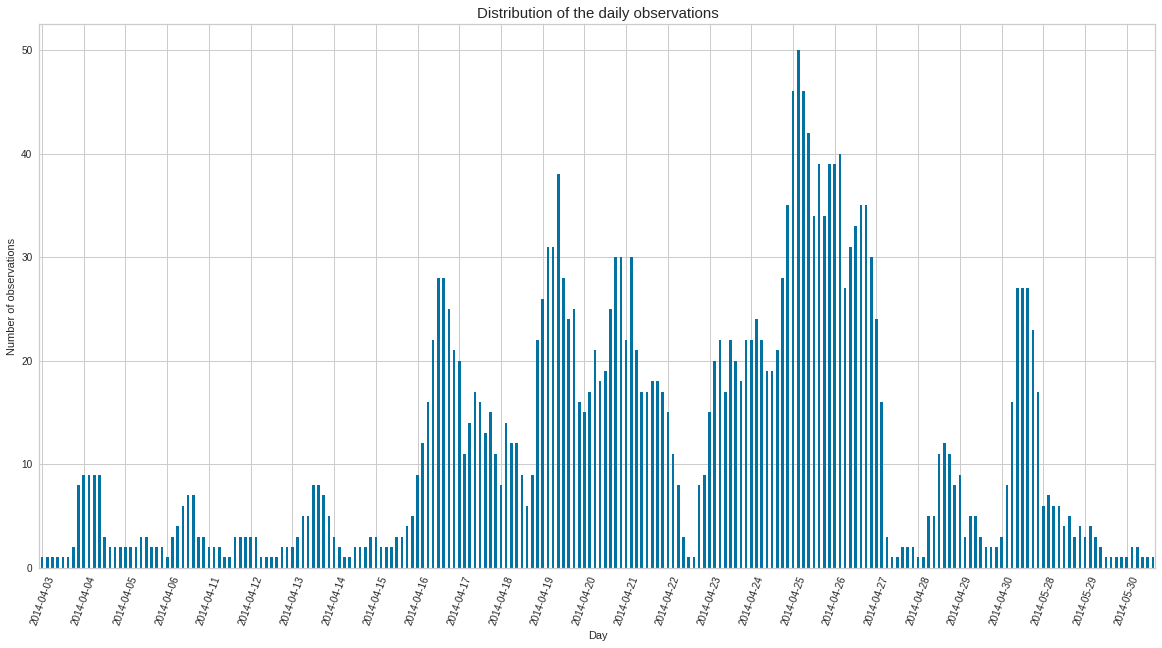

In [84]:
fig, ax = plt.subplots(figsize=(20,10))

df['datclin_day'].value_counts().sort_index().plot(kind ="bar")

ax.set_title("Distribution of the daily observations",size=15)
ax.set_xlabel('Day')
ax.set_ylabel('Number of observations')
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=70)
plt.show()

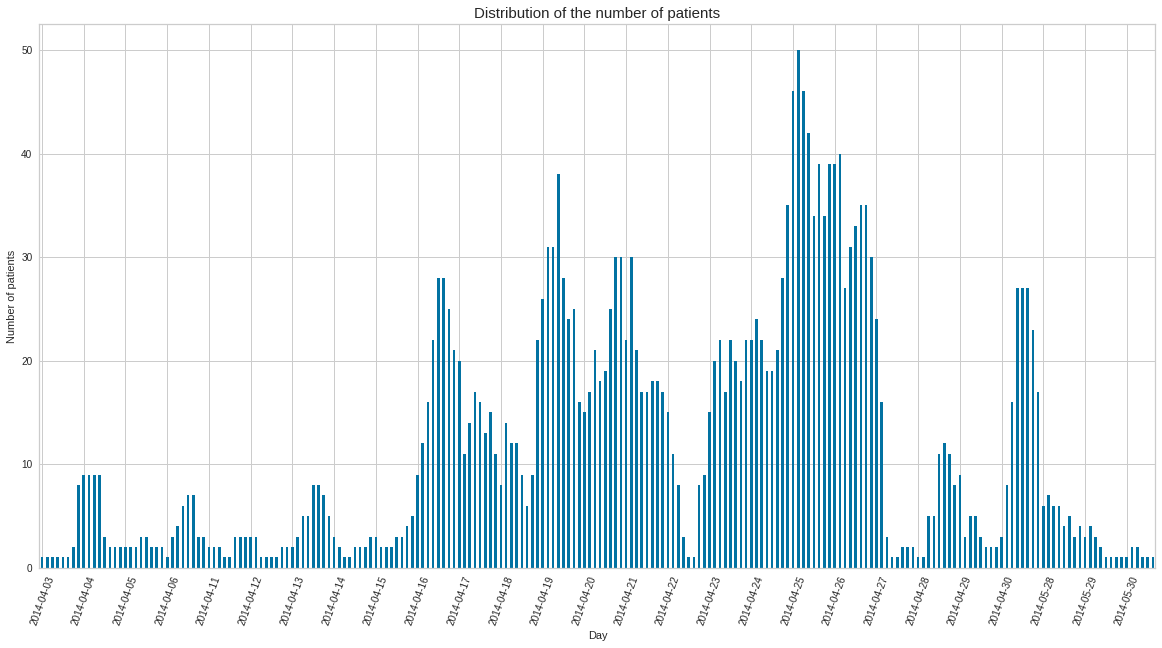

In [85]:
fig, ax = plt.subplots(figsize=(20,10))

df.groupby('datclin_day').msfid.nunique().sort_index().plot(kind ="bar")

ax.set_title("Distribution of the number of patients",size=15)
ax.set_xlabel('Day')
ax.set_ylabel('Number of patients')
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=70)
plt.show()

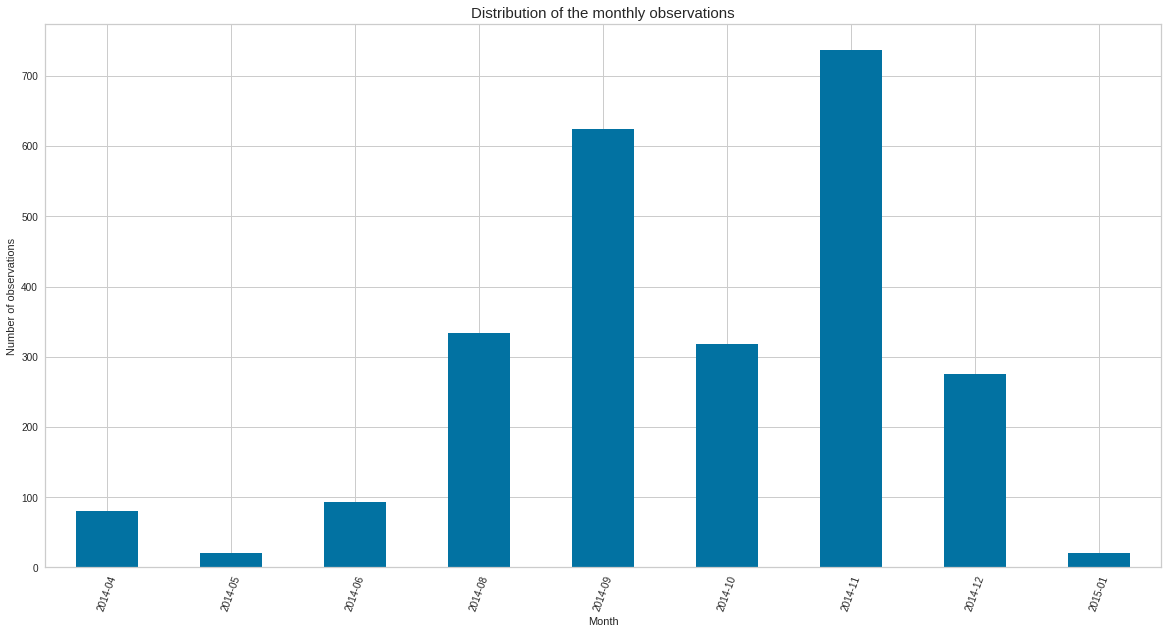

In [86]:
fig, ax = plt.subplots(figsize=(20,10))

df['datclin_month'].value_counts().sort_index().plot(kind ="bar")

ax.set_title("Distribution of the monthly observations",size=15)
ax.set_xlabel('Month')
ax.set_ylabel('Number of observations')
plt.xticks(rotation=70)
plt.show()

#### Distribution of patients within the day

Please beware, this is plot for the initial dataframe (not with the 5 consecutive patients at the clinic dataframe)

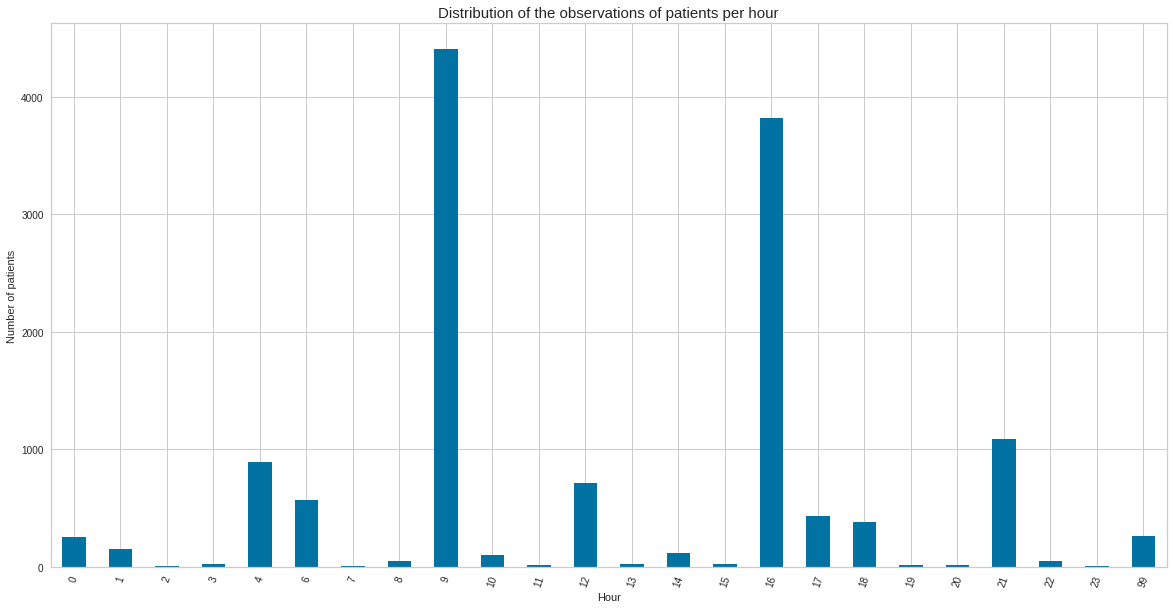

In [87]:
fig, ax = plt.subplots(figsize=(20,10))

df_clinical['timclin'].value_counts().sort_index().plot(kind ="bar")

ax.set_title("Distribution of the observations of patients per hour",size=15)
ax.set_xlabel('Hour')
ax.set_ylabel('Number of patients')
plt.xticks(rotation=70)
plt.show()

The unknown hours are represented by 99.

## Features

### Categorical symptoms

Dictionary to the symptoms can be found in the data folder

In [88]:

symptoms = ['ceph', 'asthen', 'myalc', 'arthralc', 'fevr', 'oedc', 'chocc', 'anurc', 'convc', 'swallow', 'hiccups', \
            'anorc', 'nausc', 'vomit','abdopain', 'abdosens', 'doulqs', 'diarrc', 'gastro', 'cough', 'dyspc', 'resp', \
            'chestpain', 'vertpain', 'lombar', 'ictc', 'pruri', 'hepmeg', 'splenmeg', 'erupcut', 'deshyd', 'photoc', \
            'occulair', 'tremb', 'friss', 'vert', 'amenn', 'pros', 'desor', 'agitc', 'injconj', 'epista', \
            'gum', 'hemopty', 'hematem', 'stool', 'hemat', 'vagbl', 'injbl', 'petc']

In [89]:
df_symp = df[symptoms].copy()
df_symp.head()

,ceph,asthen,myalc,arthralc,fevr,oedc,chocc,anurc,convc,swallow,...,injconj,epista,gum,hemopty,hematem,stool,hemat,vagbl,injbl,petc
0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Looking at possible missing data in symptoms

In [90]:
df_symp.isna().apply(lambda x: sum(x)).sort_values(ascending = False).head()

tremb       2291
pros        2288
occulair    2264
friss       2250
vert        2231
dtype: int64

These are the symptoms with many nan values ! We shall see their percentage and drop them in accordance

In [91]:
df_symp.fillna('Unknown', inplace = True)
df_symp.replace(1, 'Yes', inplace = True)
df_symp.replace(0, 'No', inplace = True)


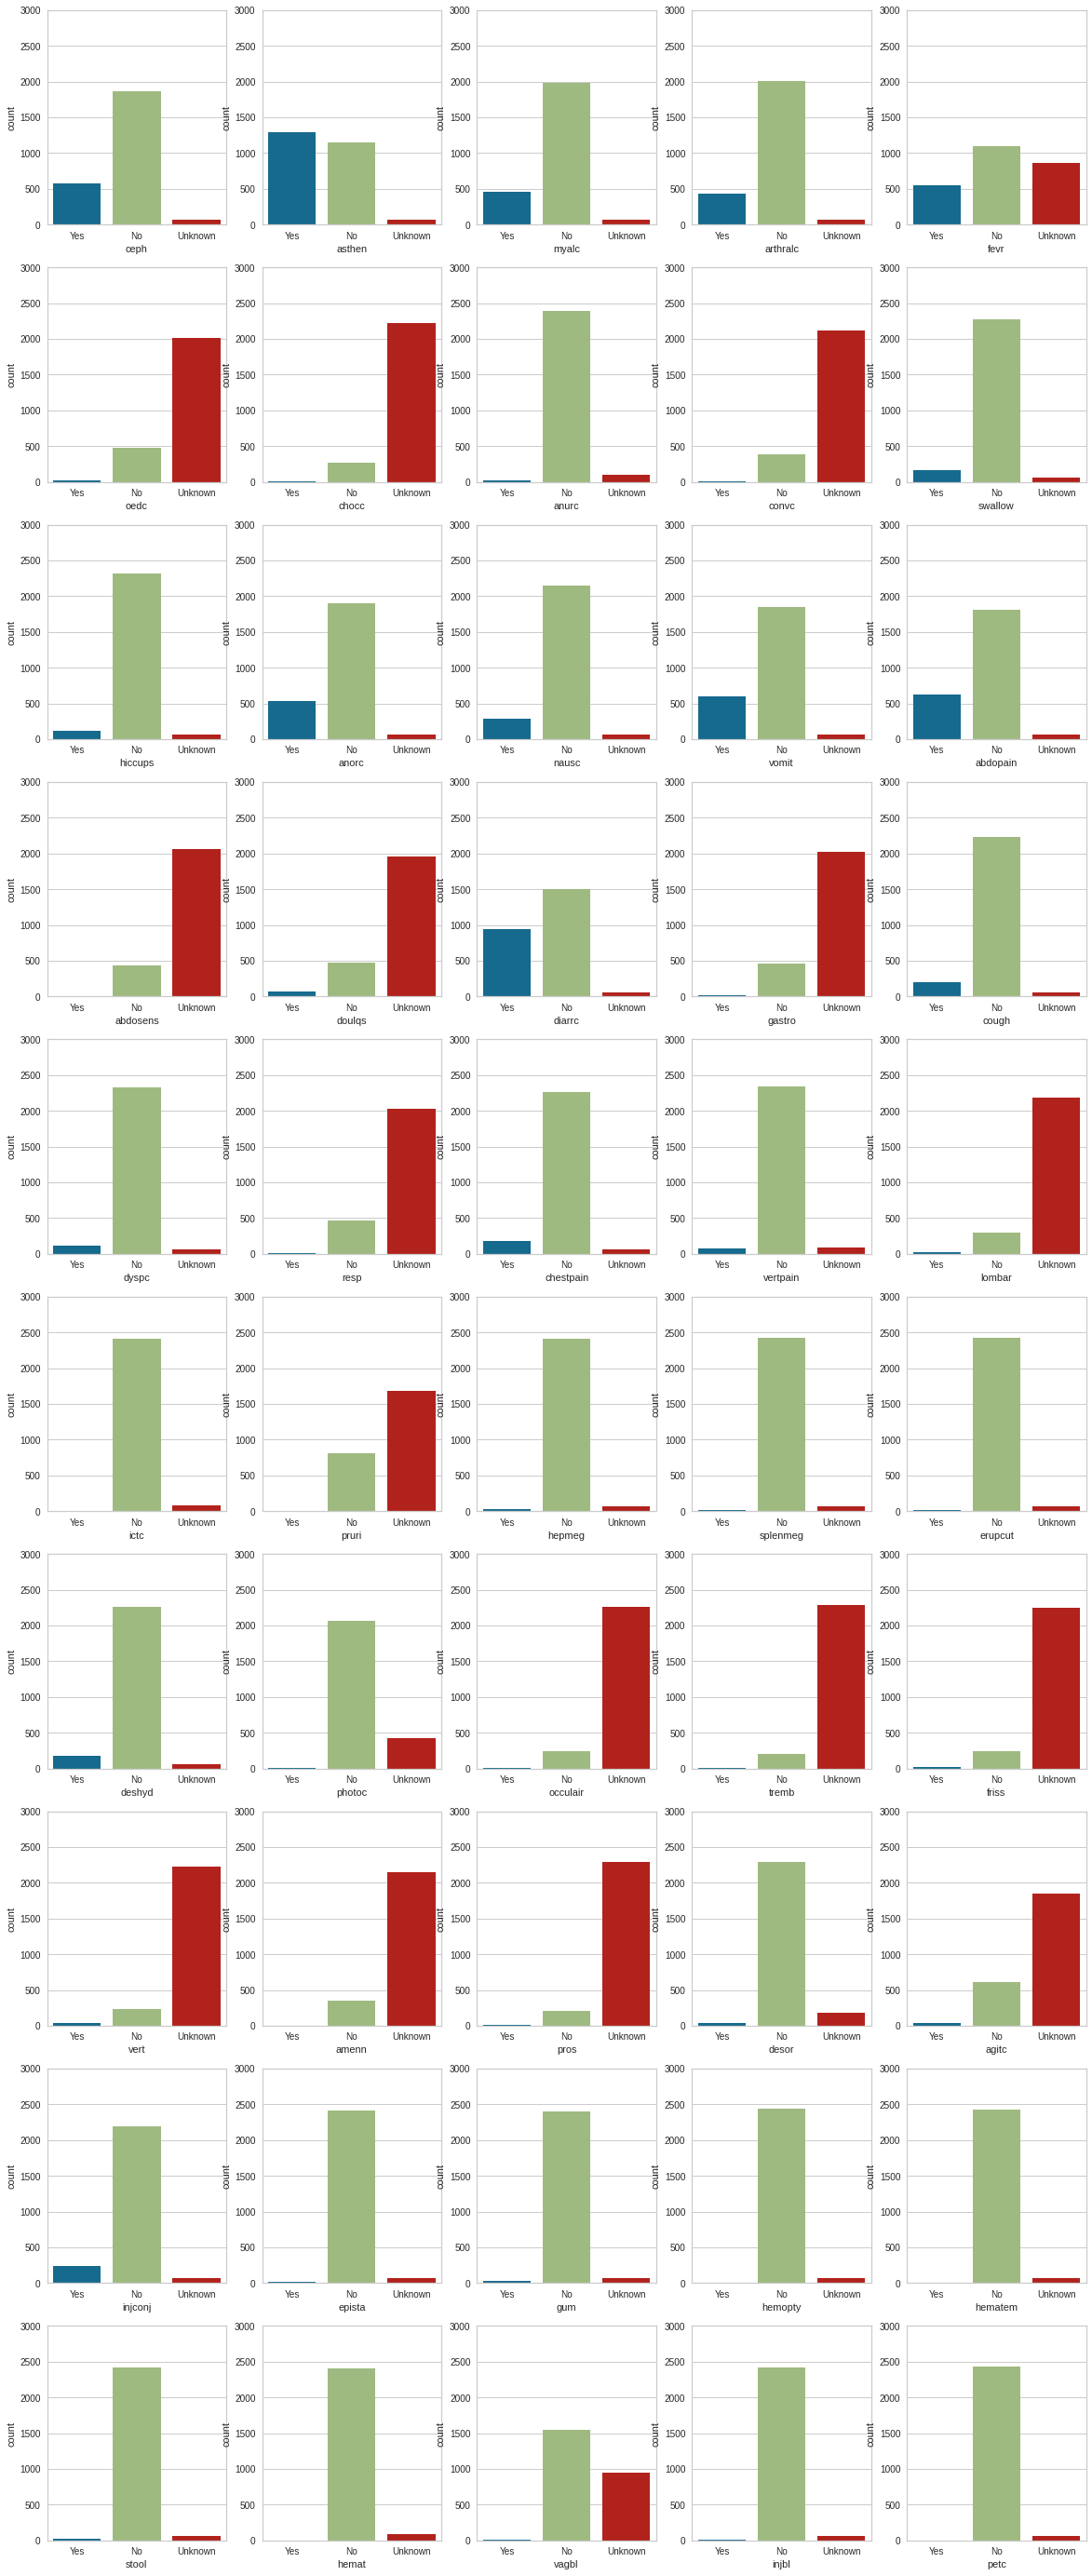

In [92]:
fig, axes = plt.subplots(nrows = 10, ncols=5, figsize=(20,50))
for ax, col in zip(axes.flatten(), df_symp.columns):
    sns.countplot(df_symp[col], ax = ax, order = ['Yes', 'No', 'Unknown'])
    #plt.title('Distribution of the symptom {}'.format(col))
    ax.set_ylim(0, 3000)

## We can already note a great deal of unknown for some features

In [93]:
yes_series = df_symp.applymap(lambda x : 1 if x== 'Yes' else 0 ).apply(lambda x :sum(x))
no_series = df_symp.applymap(lambda x : 1 if x== 'No' else 0 ).apply(lambda x :sum(x))
unknown_series = df_symp.applymap(lambda x : 1 if x== 'Unknown' else 0 ).apply(lambda x :sum(x))

In [94]:
count_symptoms = pd.concat([yes_series, no_series, unknown_series], axis=1)
count_symptoms.columns = ['Yes', 'No', 'Unknown']
total_observations = 13598
(count_symptoms / total_observations).sort_values(by ='Unknown')

,Yes,No,Unknown
diarrc,0.069201,0.110384,0.004412
asthen,0.094793,0.084718,0.004486
vomit,0.043904,0.135608,0.004486
dyspc,0.007942,0.171422,0.004633
chestpain,0.012722,0.166642,0.004633
nausc,0.021106,0.158259,0.004633
hepmeg,0.001839,0.177526,0.004633
splenmeg,0.000882,0.178482,0.004633
swallow,0.012428,0.166936,0.004633
deshyd,0.013458,0.165907,0.004633


### We look at combinations of features which are redundant or that don't bring any extra information

In [95]:
# We decide to keep both vomit and nausea
df_naus_vom = df_symp.groupby(by = ['vomit','nausc'])[['nausc']].count()
df_naus_vom.columns = ['count']
df_naus_vom

count
vomit   nausc         
No      No        1743
        Yes        101
Unknown Unknown     61
Yes     No         409
        Unknown      2
        Yes        186

In [96]:
# abdosens does not bring much valuable infomration here, we remove it 

# Both abdosens and doulqs refer to pain in the chest area
df_sens = df_symp.groupby(by = ['abdosens','doulqs'])[['doulqs']].count()
df_sens.columns = ['count']
df_sens

count
abdosens doulqs        
No       No         416
         Unknown      2
         Yes         10
Unknown  No          50
         Unknown   1952
         Yes         65
Yes      No           2
         Unknown      5

In [97]:
df_symp = df_symp.drop(columns = ['abdosens'])

In [98]:
# Let's look at two similar breathing problems 
#Dyspnée (Short of Breath)
#signes détresse respiratry

df_resp = df_symp.groupby(by = ['dyspc','resp'])[['resp']].count()
df_resp.columns = ['count']
df_resp

count
dyspc   resp          
No      No         437
        Unknown   1892
        Yes          2
Unknown Unknown     63
Yes     No          26
        Unknown     79
        Yes          3

In [99]:
df_symp = df_symp.drop(columns = ['resp'])

In [100]:
# Back pain
df_back = df_symp.groupby(by = ['lombar','vertpain'])[['vertpain']].count()
df_back.columns = ['count']
df_back


count
lombar  vertpain       
No      No          283
        Yes           8
Unknown No         2035
        Unknown      90
        Yes          59
Yes     No           23
        Yes           4

In [101]:
df_symp = df_symp.drop(columns = ['lombar'])

In [102]:
# Eye pain/sensitivity
df_eye = df_symp.groupby(by = ['photoc','occulair'])[['occulair']].count()
df_eye.columns = ['count']
df_eye

# we can remove occulair as it provides no additional information

count
photoc  occulair       
No      No          236
        Unknown    1832
        Yes           2
Unknown Unknown     426
Yes     Unknown       6

In [103]:
df_symp = df_symp.drop(columns = ['occulair'])

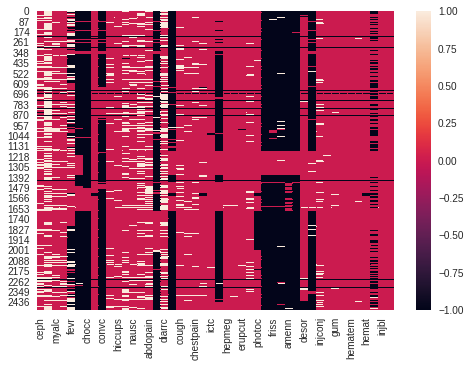

In [104]:
df_symp.eq('Unknown', axis=0).all(1)
sns.heatmap(df_symp.applymap(lambda x : 1 if x== 'Yes' else 0 if x == 'No' else -1 ))

The black corresponds to unknowns

In [105]:
tot_rows = len(df_symp);

### Features with a great number of missing values

We need to be careful when removing entire columns in the daily observation as some observations may have been weekly or every so days

In [106]:
cols = df_symp.columns

df_symp[cols].eq('Unknown').sum(axis=0)/tot_rows

# remove after 20 % 

# This represents the percentage of unknowns per feature (symptoms) the lower the better

ceph         0.025580
asthen       0.024380
myalc        0.025180
arthralc     0.025580
fevr         0.342926
oedc         0.805356
chocc        0.888489
anurc        0.036771
convc        0.846123
swallow      0.025180
hiccups      0.025580
anorc        0.025580
nausc        0.025180
vomit        0.024380
abdopain     0.025979
doulqs       0.782974
diarrc       0.023981
gastro       0.807754
cough        0.025180
dyspc        0.025180
chestpain    0.025180
vertpain     0.035971
ictc         0.033173
pruri        0.673861
hepmeg       0.025180
splenmeg     0.025180
erupcut      0.027178
deshyd       0.025180
photoc       0.170264
tremb        0.915667
friss        0.899281
vert         0.891687
amenn        0.860512
pros         0.914468
desor        0.071143
agitc        0.738209
injconj      0.025979
epista       0.025580
gum          0.025580
hemopty      0.025580
hematem      0.025580
stool        0.025580
hemat        0.034373
vagbl        0.378497
injbl        0.025979
petc      

### We decide to remove features (columns) with more than 20% missing data

In [107]:
list_keep = df_symp[cols].eq('Unknown').sum(axis=0)/tot_rows < 0.2


In [108]:
# New symptoms dataframe we keep 
df_symp = df_symp[df_symp.columns[list_keep]]


In [109]:
df_symp.head()

,ceph,asthen,myalc,arthralc,anurc,swallow,hiccups,anorc,nausc,vomit,...,desor,injconj,epista,gum,hemopty,hematem,stool,hemat,injbl,petc
0,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
1,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
2,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
3,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
4,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No


It is interesting to note that the feautures with few missing values come from similar observations, but we cannot remove them as this would cause problems when concatenating on the days.
In other words, the same observations (not patients) seem to be causing the missing datas in the features above, but, if we remove these observations, since the dataframe is given for each patient every day, we might remove day one from patient one, but then, this patient will have its first day filled with nans. 

We shall therefore proceed with more pre-processing further down

In [110]:
# adding the patients identifier and date of arrival at the clinic
df_symp = df_symp.join(pd.DataFrame(df[['datclin','msfid']]))

In [111]:
df_symp.replace('Yes', 1, inplace=True)
df_symp.replace('No', 0, inplace=True)
df_symp.replace('Unknown', np.nan, inplace=True)

### Further data analysis 

We will drop the feature "cta" where the dictionary does is "not sure" of what it is and alos dup (no legend on dictionary)



In [112]:
df['cta'].value_counts(dropna=False)

0.0    1500
NaN     904
1.0      98
Name: cta, dtype: int64

In [113]:
df['dup'].value_counts(dropna=False)

0    2497
1       5
Name: dup, dtype: int64

In [114]:
df.drop(columns = ['dup','cta'], axis = 1, inplace = True)

### Treatments 
Parat: test for malaria
Malari: Malaria positive or negative, we therefore decide to keep "malari"

In [115]:
df['malari'].value_counts(dropna=False)

0.0    1341
NaN     880
1.0     281
Name: malari, dtype: int64

In [116]:
df['parat'].value_counts(dropna=False)

0.0    1281
NaN     843
1.0     378
Name: parat, dtype: int64

In [117]:
cols_treat = ['coartt', 'artest', 'ppnt',\
       'orst', 'paracett', 'ciprot', 'cefixt', 'ceftriaxt', 'multivitt',\
       'metaclot', 'omept', 'diazt', 'tramadt', 'ctrz','metro',\
       'amox', 'prometh', 'amoclav', 'genta', 'ampi', 'albend', 'azithro',\
       'chlor', 'morph', 'tetra', 'fluco', 'mysta', 'busco', 'miso',\
       'zinc', 'ivcare', 'rlt', 'rltg', 'rltk', 'gluc',\
       'perfal']
df_treat = df[cols_treat]

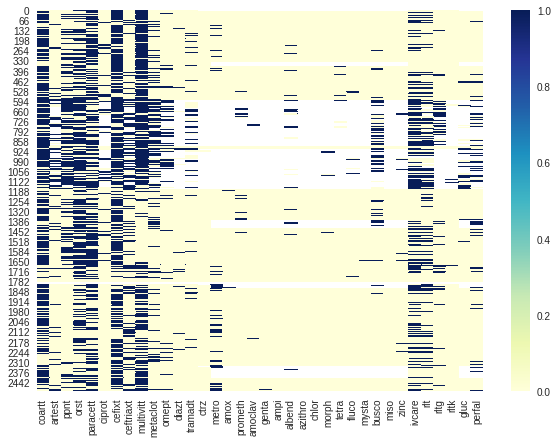

In [118]:
f, ax = plt.subplots(figsize=(10, 7))

ax = sns.heatmap(df_treat, cmap="YlGnBu")



#### Let us look at percentages with missing values in the treatments dataset


In [119]:
# % of missing values, if higher than 20% byebye
df_treat.isna().mean()

coartt       0.084732
artest       0.233014
ppnt         0.139488
orst         0.117906
paracett     0.107914
ciprot       0.248601
cefixt       0.093525
ceftriaxt    0.218225
multivitt    0.057154
metaclot     0.189848
omept        0.234612
diazt        0.276579
tramadt      0.241807
ctrz         0.292966
metro        0.364908
amox         0.368505
prometh      0.365707
amoclav      0.366906
genta        0.368905
ampi         0.368905
albend       0.356115
azithro      0.369305
chlor        0.369305
morph        0.366507
tetra        0.366507
fluco        0.365707
mysta        0.369305
busco        0.316547
miso         0.369305
zinc         0.365308
ivcare       0.169464
rlt          0.185452
rltg         0.247802
rltk         0.278977
gluc         0.336930
perfal       0.340528
dtype: float64

In [120]:
list_keep = df_treat[cols_treat].isna().mean() < 0.2


In [121]:
df_treat = df_treat[df_treat.columns[list_keep]]

In [122]:
# This is to help us merge later
df_treat = df_treat.join(pd.DataFrame(df[['msfid','datclin']]))

### Other "sicknesses"

In [123]:
cols_test = ['malari', 'hivpos', 'mningit', 'encphal', 'erysip', \
       'cardio', 'fessier', 'epilep', 'mendis']

df_tests = df[cols_test]

In [124]:
# We also have the outcome, but it needs its own dictionary ! 
df_clinical['outcome'].value_counts(dropna=False)

1    8285
2    5111
3      25
4       2
Name: outcome, dtype: int64

#### We are however only interested in healed or deceased in our case (for the outcome)
1	Guéri : Healed --> change to 0 for healed
2	Décédé : Deceased -- > changed to 1 for deceased
3	Transferé : Transfered
4	Evadé : Escaped
9	Non rempli : Not filled in


In [125]:
dict_outcome = {1:0, 2:1, 9:np.nan, '.':np.nan, '0': np.nan,'1':1,'2':0,'4':np.nan,'3':np.nan}

In [126]:
df_5_days['outcome']= pd.DataFrame(data = df_5_days['outcome'].apply(lambda x : dict_outcome[x]))

<ipython-input-126-b9ab4bb395cf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5_days['outcome']= pd.DataFrame(data = df_5_days['outcome'].apply(lambda x : dict_outcome[x]))


#### Let us look at percentages with missing values in the treatments dataset
It is very high, but this might because we test the person once and that's it, so we it would be more accurate to verify that each patient has at least one non nan value


In [127]:
df_tests.isna().mean()

malari     0.351719
hivpos     0.852918
mningit    0.854516
encphal    0.854916
erysip     0.854916
cardio     0.854117
fessier    0.853717
epilep     0.854916
mendis     0.846523
dtype: float64

In [128]:
# We looked for each column, if each patient was tested at least once but no
df.groupby('msfid').sum()['mningit'].value_counts()

0.0    517
1.0      1
Name: mningit, dtype: int64

In [129]:
# With the table above showing that only the malaria test has "usuable information" and with noting that most of the other
# features are nan or "no" (very few exceptions) we keep only malaria 

In [130]:
df_tests= df_tests.join(df['msfid'])

In [131]:
dict_read_tests = {
    0  : 1,
    1  : 100,
    '0': 1,
    '1': 100,
    'NaN': 0
}

df_tests['malari'] = df_tests['malari'].fillna('NaN').apply(lambda x : dict_read_tests[x])

In [132]:
df_te = df_tests[['malari','msfid']]

In [133]:
df_tr_count = df_te.groupby(by = 'msfid').sum()


In [134]:
df_tr_count.head()

,malari
msfid,
G100,0
G1002,4
G1005,5
G1006,5
G1007,5


In [135]:
# We proceed the same way we did for the symptoms, to see if each patient was tested at least once
df_tr_count[(df_tr_count['malari'] == 0)] = np.nan
df_tr_count[(df_tr_count['malari'] < 99)] = 0
df_tr_count[(df_tr_count['malari'] > 99)] = 1


In [136]:
df_tr_count.head()

,malari
msfid,
G100,NaN
G1002,0.0
G1005,0.0
G1006,0.0
G1007,0.0


In [137]:
df_5_days[['outcome','msfid']].groupby(by='msfid').nunique()['outcome'].value_counts()

1    517
0      1
Name: outcome, dtype: int64

#### We noticed some observations had nan values in outcome, since we are trying to predict it, we cannot keep that

In [138]:

df_5_days['outcome'].value_counts(dropna= False)

1.0    3448
0.0    2492
NaN       9
Name: outcome, dtype: int64

In [139]:
# Here we see it's the same patient with an unknown outcome, we thus disregard the patient
df_5_days[df_5_days['outcome'].isna()]

,msfid,datclin,timclin,unid,ceph,asthen,myalc,arthralc,fevr,oedc,...,notesread,dup,datsym,epistat,outcome,age,sex,dt,first_date,Time_stayed
2238,G674,2014-08-21,16,G674_21aug2014_16,1,1,0,0,8,8,...,Yes,0,2014-08-16,1.0,NaN,40.0,1.0,5.0,2014-08-21,11
2239,G674,2014-08-22,6,G674_22aug2014_6,0,1,0,0,8,8,...,Yes,0,2014-08-16,1.0,NaN,40.0,1.0,6.0,2014-08-21,11
2240,G674,2014-08-22,11,G674_22aug2014_11,0,0,0,0,8,8,...,Yes,0,2014-08-16,1.0,NaN,40.0,1.0,6.0,2014-08-21,11
2257,G674,2014-08-23,21,G674_23aug2014_21,0,0,0,0,8,8,...,Yes,0,2014-08-16,1.0,NaN,40.0,1.0,7.0,2014-08-21,11
2258,G674,2014-08-23,16,G674_23aug2014_16,0,0,0,0,8,8,...,Yes,0,2014-08-16,1.0,NaN,40.0,1.0,7.0,2014-08-21,11
2259,G674,2014-08-22,21,G674_22aug2014_21,0,0,0,0,8,8,...,Yes,0,2014-08-16,1.0,NaN,40.0,1.0,6.0,2014-08-21,11
2260,G674,2014-08-25,21,G674_25aug2014_21,0,0,0,0,8,8,...,Yes,0,2014-08-16,1.0,NaN,40.0,1.0,9.0,2014-08-21,11
2261,G674,2014-08-25,9,G674_25aug2014_9,0,1,0,0,8,1,...,Yes,0,2014-08-16,1.0,NaN,40.0,1.0,9.0,2014-08-21,11
2262,G674,2014-08-24,16,G674_24aug2014_16,0,0,0,0,8,8,...,Yes,0,2014-08-16,1.0,NaN,40.0,1.0,8.0,2014-08-21,11


In [140]:
# We remove the patient who's outcome is unknown 
df_5_days = df_5_days[df_5_days['msfid'] != 'G674']

In [141]:
# We put max as a patient who was once dead is not coming back alive 
df_out = df_5_days[['outcome','msfid']].groupby(by = 'msfid').max().reset_index()

In [142]:
df_extract = pd.DataFrame(data = df[['msfid','sex','age','datclin','datsym', 'dt','first_date','Time_stayed']])
df_extract

,msfid,sex,age,datclin,datsym,dt,first_date,Time_stayed
0,G100,1.0,40.0,2014-04-11,2014-04-09,2.0,2014-04-11,10
1,G100,1.0,40.0,2014-04-12,2014-04-09,3.0,2014-04-11,10
2,G100,1.0,40.0,2014-04-13,2014-04-09,4.0,2014-04-11,10
3,G100,1.0,40.0,2014-04-14,2014-04-09,5.0,2014-04-11,10
4,G100,1.0,40.0,2014-04-15,2014-04-09,6.0,2014-04-11,10
...,...,...,...,...,...,...,...,...
2497,G998,1.0,6.0,2014-09-17,2014-09-18,-1.0,2014-09-17,9
2498,G998,1.0,6.0,2014-09-18,2014-09-18,0.0,2014-09-17,9
2499,G998,1.0,6.0,2014-09-19,2014-09-18,1.0,2014-09-17,9
2500,G998,1.0,6.0,2014-09-20,2014-09-18,2.0,2014-09-17,9


In [143]:
df_pre =df_out.merge(df_tr_count, how = 'inner', on = 'msfid').merge(df_treat,how = 'inner', on = 'msfid').merge(df_extract,how = 'inner', on = ['msfid','datclin']).merge(df_symp,how = 'inner', on = ['msfid','datclin'])

In [144]:
df_pre['outcome'].value_counts()

1.0    1469
0.0    1028
Name: outcome, dtype: int64

#### We finally have a data frame that is grouped by day with each patient, whose outcomes are known 

# Separation between days 

We will now concatenate using a "home-made" function which you can learn more about on the helper/read_me the different days, each patient will thus have 5 consecutive days of features which change with time

In [145]:
df_day = transform_into_horizontal_df(df_pre)

In [146]:
df_day.head()

,msfid,malari,coartt,ppnt,orst,paracett,cefixt,multivitt,metaclot,ivcare,...,hemopty,hematem,stool,hemat,injbl,petc,time_elapsed,sex,age,outcome
0,G100,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4 days,1.0,40.0,1.0
1,G1002,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4 days,2.0,12.0,1.0
2,G1005,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4 days,1.0,11.0,0.0
3,G1006,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,4 days,2.0,20.0,1.0
4,G1007,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4 days,1.0,50.0,1.0


In [147]:
# code taken from stackoverflow 
#(https://stackoverflow.com/questions/43095955/rename-duplicated-index-values-pandas-dataframe)
def differentiante_names(data_frame):
    df_transposed = data_frame.transpose(copy=True)
    df_transposed.index = df_transposed.index + df_transposed.groupby(level=0).cumcount().astype(str).replace('0','')
    return df_transposed.transpose(copy=True)

In [148]:
df_days = differentiante_names(df_day)

In [149]:
df_days.head()

,msfid,malari,coartt,ppnt,orst,paracett,cefixt,multivitt,metaclot,ivcare,...,hemopty4,hematem4,stool4,hemat4,injbl4,petc4,time_elapsed4,sex,age,outcome
0,G100,NaN,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,4 days,1,40,1
1,G1002,0,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,4 days,2,12,1
2,G1005,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,4 days,1,11,0
3,G1006,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,4 days,2,20,1
4,G1007,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,4 days,1,50,1


### Since we are going to remove all NaN values by replacing them with zeros further down the line, we need to first drop the lines and columns that are too "empty"

In [150]:
threshold_column = 0.2
percentage0 = len(df_days)*threshold_column


bad_columns= df_days.columns[df_days.isna().sum(axis=0)>percentage0]
bad_columns

Index(['malari', 'metaclot', 'ivcare', 'rlt', 'malari1', 'metaclot1',
       'ivcare1', 'rlt1', 'photoc1', 'malari2', 'metaclot2', 'ivcare2', 'rlt2',
       'photoc2', 'malari3', 'malari4'],
      dtype='object')

In [151]:
#Sadly we can't operate with too many NaN's so we just abandon them.
df_days.drop(columns=bad_columns, inplace=True)

In [152]:
threshold_rows = 0.2
percentage1 = len(df_days.columns)*threshold_rows


bad_rows = df_days.index[df_days.isna().sum(axis=1)>percentage1]
print(bad_rows)
print(df_days.iloc[bad_rows]['msfid'])

Int64Index([  1,   7,  10,  18,  26,  33,  41,  46,  47,  48,  66, 124, 127,
            138, 155, 165, 168, 171, 172, 173, 174, 240, 282, 290, 292, 298,
            347, 350, 362, 364, 367, 390, 392, 396, 401, 406, 409, 412, 434,
            443, 446, 460, 463, 473, 474, 475, 476, 480, 481, 482, 484, 485,
            486, 487, 490, 491, 492, 502, 504, 505, 506, 508],
           dtype='int64')
1      G1002
7      G1010
10     G1015
18     G1029
26     G1040
       ...  
502     G971
504     G978
505     G979
506     G980
508     G986
Name: msfid, Length: 62, dtype: object


In [153]:
#Same here, we can't operate with too many NaN's so we just abandon them.
df_days.drop(index=bad_rows, inplace=True)

### Now we take care of the columns we don't need anymore 
e.g. the time references columns

In [154]:
df_days[['time_elapsed', 'time_elapsed1', 'time_elapsed2', 'time_elapsed3', 'time_elapsed4']].head()

,time_elapsed,time_elapsed1,time_elapsed2,time_elapsed3,time_elapsed4
0,0 days,1 days,2 days,3 days,4 days
2,0 days,1 days,2 days,3 days,4 days
3,0 days,1 days,2 days,3 days,4 days
4,0 days,1 days,2 days,3 days,4 days
5,0 days,1 days,2 days,3 days,4 days


In [155]:
# These columns d'ont add anything to our models now, so we can discard them:

df_days.drop(columns=['time_elapsed', 'time_elapsed1', 'time_elapsed2', 'time_elapsed3', 'time_elapsed4'], inplace=True)

In [156]:
# Keep on, look for other notebook

In [157]:
# Same with and 'first_date'
df_days.drop(columns=['datclin1', 'datclin2', 'datclin3', 'datclin4', 'first_date', 'first_date1', 'first_date2', 'first_date3', 'first_date4'], inplace=True)
df_days.head()

,msfid,coartt,ppnt,orst,paracett,cefixt,multivitt,datclin,Time_stayed,ceph,...,gum4,hemopty4,hematem4,stool4,hemat4,injbl4,petc4,sex,age,outcome
0,G100,0,0,0,1,0,0,2014-04-11,10,0,...,0,0,0,0,0,0,0,1,40,1
2,G1005,0,1,1,0,0,0,2014-09-16,7,1,...,0,0,0,0,0,0,0,1,11,0
3,G1006,NaN,NaN,NaN,NaN,NaN,NaN,2014-09-16,9,0,...,0,0,0,0,0,0,0,2,20,1
4,G1007,0,0,0,0,1,1,2014-09-19,8,0,...,0,0,0,0,0,0,0,1,50,1
5,G1008,1,0,0,1,1,1,2014-09-19,6,0,...,0,0,0,0,0,0,0,2,29,0


In [158]:
# Same with 'Time_stayed' 
df_days.drop(columns=['Time_stayed', 'Time_stayed1', 'Time_stayed2', 'Time_stayed3', 'Time_stayed4'], inplace=True)


### Now some one-hot encoding for 'sex' 

In [159]:
df_days['sex'].value_counts(dropna = False)

1.0    246
2.0    209
Name: sex, dtype: int64

In [160]:
# To encode them, first change their labels into something easier to understand : F for Female, M for Male and U for Unknown
dict_sex = {1: 'F', 2:'M', 9: 'U'}
df_days_sex = df_days['sex'].apply(lambda x : dict_sex[x])
df_days_sex.head()

0    F
2    F
3    M
4    F
5    M
Name: sex, dtype: object

In [161]:
df_days_sex_encoded = df_days.join(pd.get_dummies(df_days_sex, prefix='sex'), how='inner')

In [162]:
df_days_sex_encoded.drop(columns='sex', inplace=True)

### Now we replace the remaining NaNs with 0

In [163]:
df_days_sex_encoded.isna().mean()

msfid       0.000000
coartt      0.092308
ppnt        0.140659
orst        0.129670
paracett    0.118681
              ...   
petc4       0.010989
age         0.000000
outcome     0.000000
sex_F       0.000000
sex_M       0.000000
Length: 200, dtype: float64

In [164]:
# We assume the remaining Nans are from missing indications in prescriptions or symptoms, which might mean that they didn't have it

df_clean = df_days_sex_encoded.fillna(0)
df_clean.head()

,msfid,coartt,ppnt,orst,paracett,cefixt,multivitt,datclin,ceph,asthen,...,hemopty4,hematem4,stool4,hemat4,injbl4,petc4,age,outcome,sex_F,sex_M
0,G100,0.0,0.0,0.0,1.0,0.0,0.0,2014-04-11,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,40.0,1.0,1,0
2,G1005,0.0,1.0,1.0,0.0,0.0,0.0,2014-09-16,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,1,0
3,G1006,0.0,0.0,0.0,0.0,0.0,0.0,2014-09-16,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,20.0,1.0,0,1
4,G1007,0.0,0.0,0.0,0.0,1.0,1.0,2014-09-19,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,50.0,1.0,1,0
5,G1008,1.0,0.0,0.0,1.0,1.0,1.0,2014-09-19,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0,1


In [165]:
# Change datclin into a number (the nth day of the year)
df_clean['datclin'] = pd.to_datetime(df_clean['datclin'])
df_clean['datclin_day'] = df_clean['datclin'].dt.to_period('D')
df_clean['datclin_dayofyear'] = df_clean['datclin_day'].dt.dayofyear
df_clean.drop(columns=['datclin_day', 'datclin'], inplace=True)

# Data Visualization

In [166]:
X_out_ml = df_clean.drop(columns = ['outcome', 'msfid'])
y_out_ml = df_clean['outcome'].astype(int)

Just a quick look at the columns which might have same info in all entrie (-> not usefull)

In [167]:
new_bad_columns= X_out_ml.columns[X_out_ml.std() == 0]
new_bad_columns

Index(['hemopty', 'hematem', 'petc', 'hemopty1', 'stool1', 'hepmeg2',
       'splenmeg2', 'hemopty2', 'hemat2', 'injbl2', 'petc2', 'photoc3',
       'hemopty3', 'hemat3', 'photoc4', 'hemat4', 'petc4'],
      dtype='object')

In [168]:
# We let them go.
X_out_ml.drop(columns=new_bad_columns, inplace=True)

### Correlation Matrix

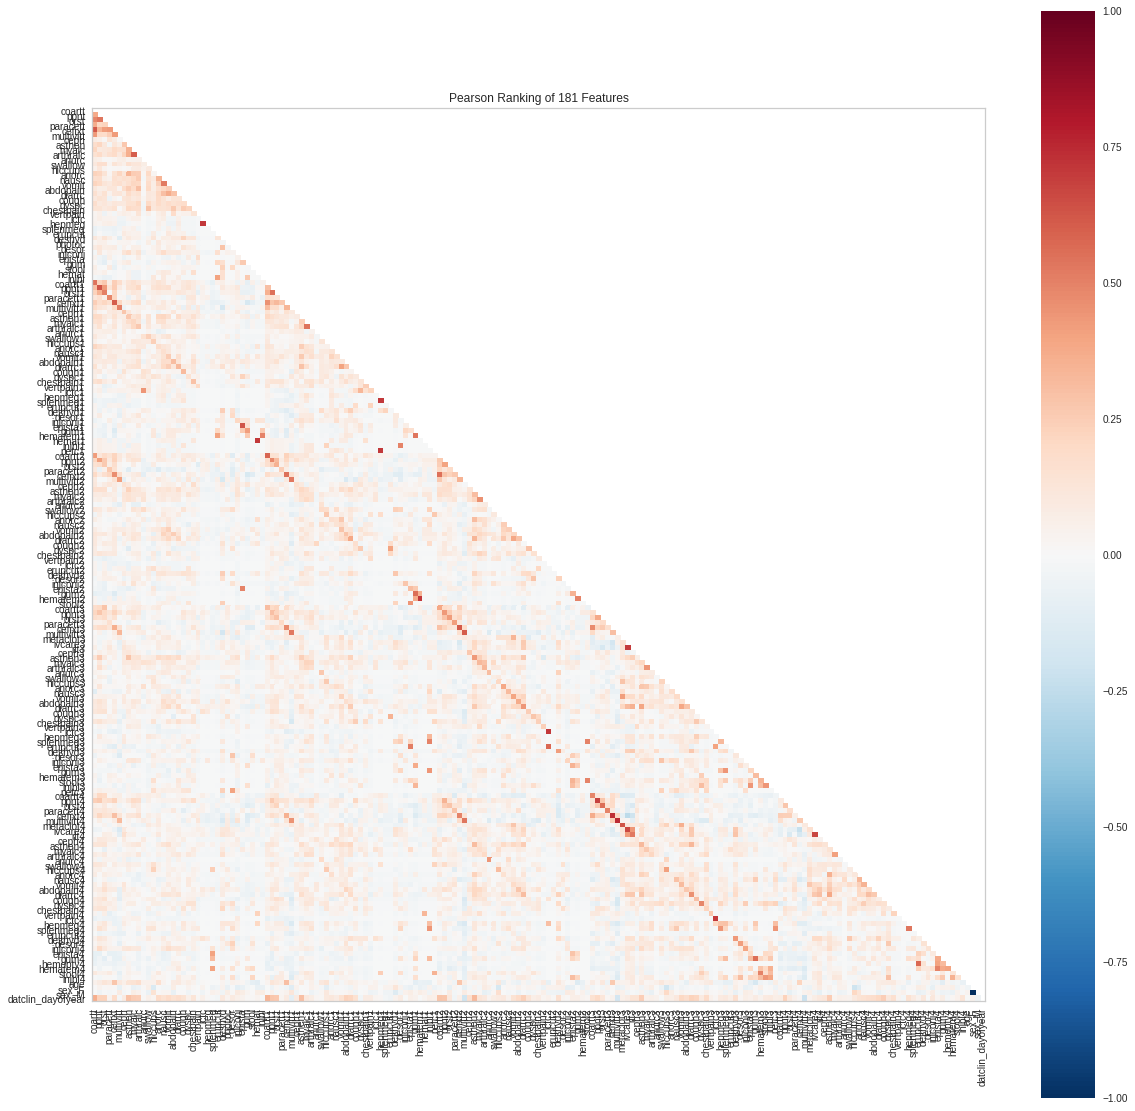

In [169]:
Corr_vision(X_out_ml)

Two things we can observe:
We can kinda see the outline of bloc-matrices inside this matrix. They correspond to the different days.
We can see a 'sub-diagonal' that is somewhat more dark than the rest. It means that each column is notably correlated to itself, but one day later, which makes total sens. We can even see a glimpse of second sub-diagonal and third but each time less dark, wich means that the correlation for a given column gets less important as time goes by.

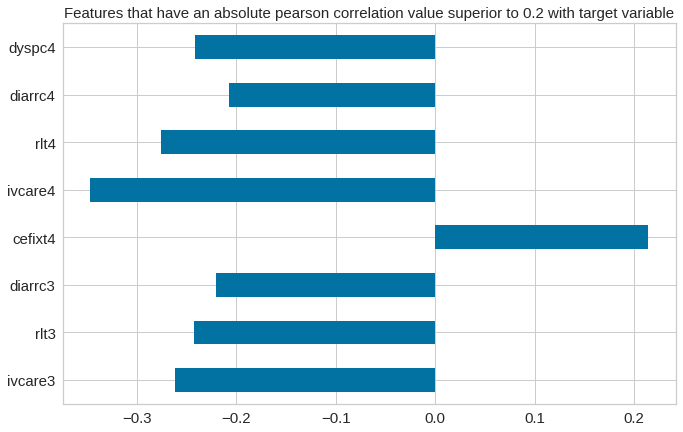

In [170]:
X_y_out = X_out_ml.join(y_out_ml, how = 'outer')
corr_matrix = X_y_out.corr()

corr_y = corr_matrix['outcome']
threshold = 0.2
fig, ax = plt.subplots(figsize=(11,7))
corr_y[corr_y.index[abs(corr_y) > threshold].tolist()].drop('outcome').plot(kind='barh', fontsize = 15)
plt.title('Features that have an absolute pearson correlation value superior to {} with target variable'.format(threshold), fontsize = 15)
plt.show()

*Above we plotted the corelation with the target values, these will be important*



### Class imbalance

Balance is important in order to get a reliable accuracy for unseen datas, if imbalanced, steps need to be taken in order to take this into account. 
A good metric to look at is precision, recall and F1, this is discussed in the report. 

In [171]:
y_out_ml.value_counts()

1    267
0    188
Name: outcome, dtype: int64

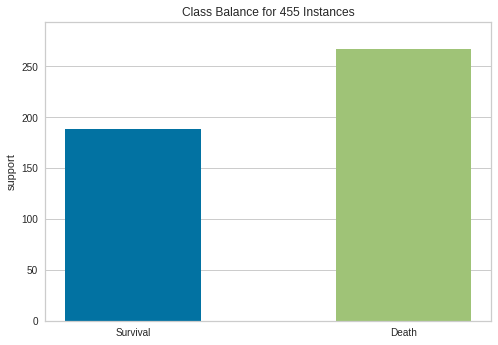

In [172]:
Imbalance_out(y_out_ml)

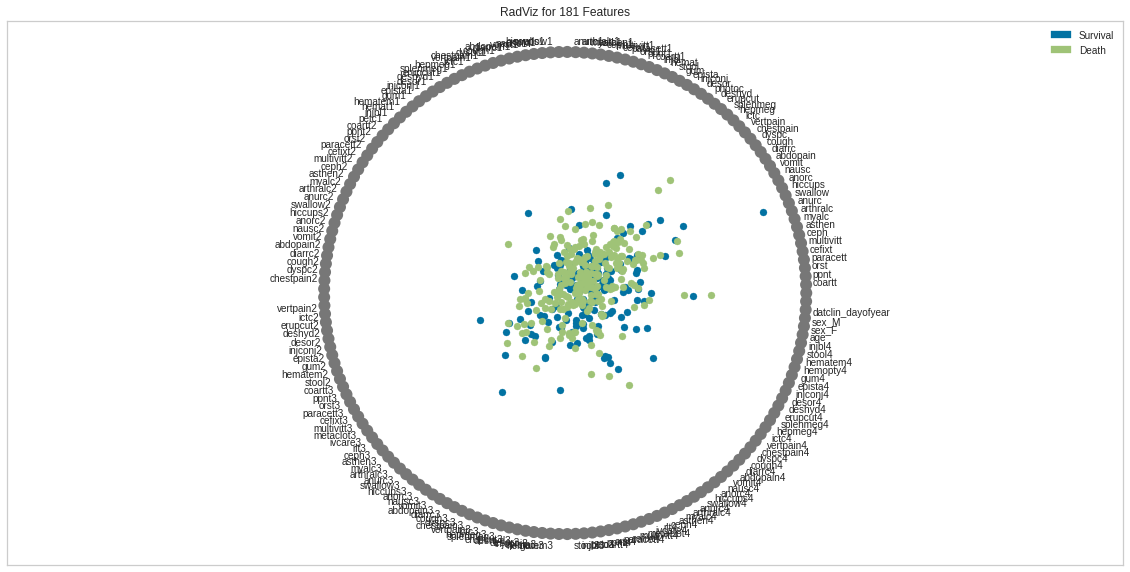

In [173]:
Rad_vision_out(X_out_ml, y_out_ml)

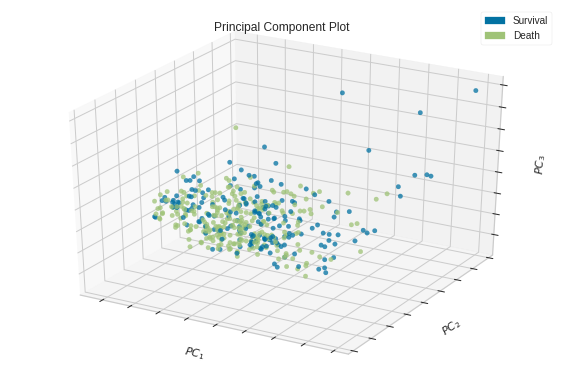

In [174]:
PCA_vision_3D_out(X_out_ml, y_out_ml)

### Split train/test

Before standardizing, we need to make sure that the dataset is split between train and test !
This is to make sure that the "way" we standardize our train set is "the base" as to how we standardize our test set.

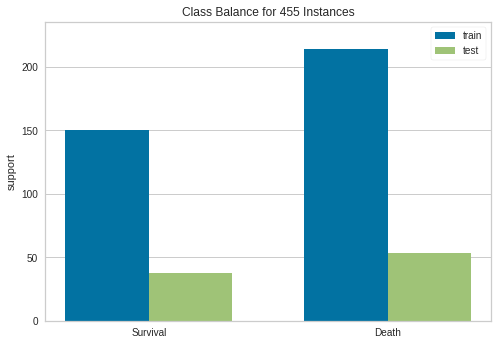

In [175]:

X_out_train, X_out_test, y_out_train, y_out_test = train_test_split(X_out_ml, y_out_ml, test_size=0.2, random_state=123, stratify=y_out_ml)


# Instantiate the visualizer
visualizer = ClassBalance(labels=['Survival', 'Death'])

visualizer.fit(y_out_train, y_out_test)        # Fit the data to the visualizer
visualizer.show()                      # Finalize and render the figure
plt.show()

### Noramlizing the data

In [177]:
X_out_train.head()

,coartt,ppnt,orst,paracett,cefixt,multivitt,ceph,asthen,myalc,arthralc,...,epista4,gum4,hemopty4,hematem4,stool4,injbl4,age,sex_F,sex_M,datclin_dayofyear
59,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0,1,272
20,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0,1,265
194,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0,1,309
503,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,58.0,0,1,258
408,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,35.0,1,0,230


In [179]:

numerical_col= X_out_train.columns[(X_out_train.loc[0] != 1.0) & (X_out_train.loc[0] != 0.0)]
numerical_col

Index(['age', 'datclin_dayofyear'], dtype='object')

In [180]:
scaler = StandardScaler()
X_out_train.loc[:,numerical_col] = scaler.fit_transform(X_out_train[numerical_col])
X_out_test.loc[:,numerical_col] = scaler.transform(X_out_test[numerical_col])

/home/lavinia/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/lavinia/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### Now that we have the training set, let's proceed with some more feature selection.

In [183]:
remove_col_null_std = X_out_train.columns[(X_out_train.apply(lambda x : np.std(x)) == 0).values].values 
remove_col_null_std


array([], dtype=object)

In [184]:
X_out_train.drop(columns = remove_col_null_std,inplace = True)
X_out_test.drop(columns = remove_col_null_std,inplace = True)

### Removing correlated features

In [185]:
corr_count = (abs(X_out_train.corr()) > 0.75).sum() 
X_out_train[corr_count[corr_count > 1].index.to_list()].corr()

,sex_F,sex_M
sex_F,1.0,-1.0
sex_M,-1.0,1.0


In [186]:
# Since all patients are either F or M, knowing one is enough. Redundant information
X_out_train.drop(columns = 'sex_M', inplace = True)
X_out_test.drop(columns = 'sex_M', inplace = True)

/home/lavinia/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,outcome
59,1
20,1
194,0
503,1
408,0
...,...
405,1
337,1
232,1
22,1


In [191]:
# Let us export the training and the test "cleaned" dataframes in order to ease the computation at the end
#Output_train_data = X_out_train.join(pd.DataFrame(y_out_train), how ='outer' )
#Output_train_data.to_csv(r'/home/lavinia/Documents/Doc_2020/EPFL/Master/Semester I/Machine Learning/Project_2/Private_folder/NoteBooks_ML/STUDIES/Clinic_train.csv',index=False)


#Output_test_data = X_out_test.join(pd.DataFrame(y_out_test), how ='outer' )
#Output_test_data.to_csv(r'/home/lavinia/Documents/Doc_2020/EPFL/Master/Semester I/Machine Learning/Project_2/Private_folder/NoteBooks_ML/STUDIES/Clinic_test.csv',index=False)

#### Tune the number of selected features

##### Recursvive feature elimination

We could have improved the RFE by using a cv version. But we decided to continue with a univariate feature selection. Where features are chosen based on univariate statistics (sklearn)
We will use SelectKBest in order to retrieve the k highest scoring features. We also also f_classif which calculates the anova F-value between the label (outcome) and the features. It estimates the dergee of linear dependency between two random variables

In [192]:

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

logreg = LogisticRegression(random_state = 123)
logreg.fit(X_out_train, y_out_train)
rfe = RFE(logreg, n_features_to_select=1)
rfe = rfe.fit(X_out_train, y_out_train)
order = rfe.ranking_
sorted(zip(order, X_out_train.columns))

[(1, 'dyspc4'),
 (2, 'ivcare4'),
 (3, 'dyspc3'),
 (4, 'gum3'),
 (5, 'epista4'),
 (6, 'deshyd1'),
 (7, 'chestpain4'),
 (8, 'desor3'),
 (9, 'swallow3'),
 (10, 'anorc3'),
 (11, 'photoc'),
 (12, 'arthralc3'),
 (13, 'cefixt4'),
 (14, 'vertpain1'),
 (15, 'diarrc3'),
 (16, 'paracett3'),
 (17, 'nausc3'),
 (18, 'datclin_dayofyear'),
 (19, 'gum4'),
 (20, 'coartt1'),
 (21, 'myalc4'),
 (22, 'diarrc4'),
 (23, 'deshyd3'),
 (24, 'epista1'),
 (25, 'hiccups3'),
 (26, 'hiccups4'),
 (27, 'injconj3'),
 (28, 'multivitt4'),
 (29, 'vomit'),
 (30, 'injconj4'),
 (31, 'multivitt1'),
 (32, 'desor4'),
 (33, 'cough2'),
 (34, 'erupcut3'),
 (35, 'chestpain1'),
 (36, 'coartt'),
 (37, 'cough3'),
 (38, 'diarrc1'),
 (39, 'rlt4'),
 (40, 'coartt4'),
 (41, 'vomit3'),
 (42, 'hepmeg'),
 (43, 'hepmeg1'),
 (44, 'myalc1'),
 (45, 'hiccups1'),
 (46, 'desor1'),
 (47, 'desor'),
 (48, 'ppnt1'),
 (49, 'coartt2'),
 (50, 'cefixt2'),
 (51, 'asthen3'),
 (52, 'anurc3'),
 (53, 'abdopain2'),
 (54, 'myalc3'),
 (55, 'anorc4'),
 (56, 'cough1')

In [193]:
# Models tested

models = [LogisticRegression(random_state = 123,solver='lbfgs'),     
    RandomForestClassifier(random_state = 123,n_estimators=300),    
    SVC(random_state=123)]

In [200]:
# Evaluate a given model using cross-validation

####### We use SVC as will be seen below it is the best model so we'll plot the accuracy of the traning set as a function of the number of (best) features choosen



def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=123)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    return scores
 
num_features = [i+1 for i in range(X_out_train.shape[1])]
results = list()

for k in num_features:
    model = SVC(random_state=123)
    fs = SelectKBest(score_func=f_classif, k=k)
    pipeline = Pipeline(steps=[('anova',fs), ('lr', model)])
    # evaluate the model
    scores = evaluate_model(pipeline, X_out_train, y_out_train)
    results.append(scores)
    if k % 20 == 0:
        print('>%d %.3f (%.3f)' % (k, np.mean(scores), np.std(scores)))

>20 0.710 (0.044)
>40 0.729 (0.060)
>60 0.726 (0.047)
>80 0.726 (0.047)
>100 0.719 (0.047)
>120 0.714 (0.045)
>140 0.713 (0.049)
>160 0.709 (0.050)


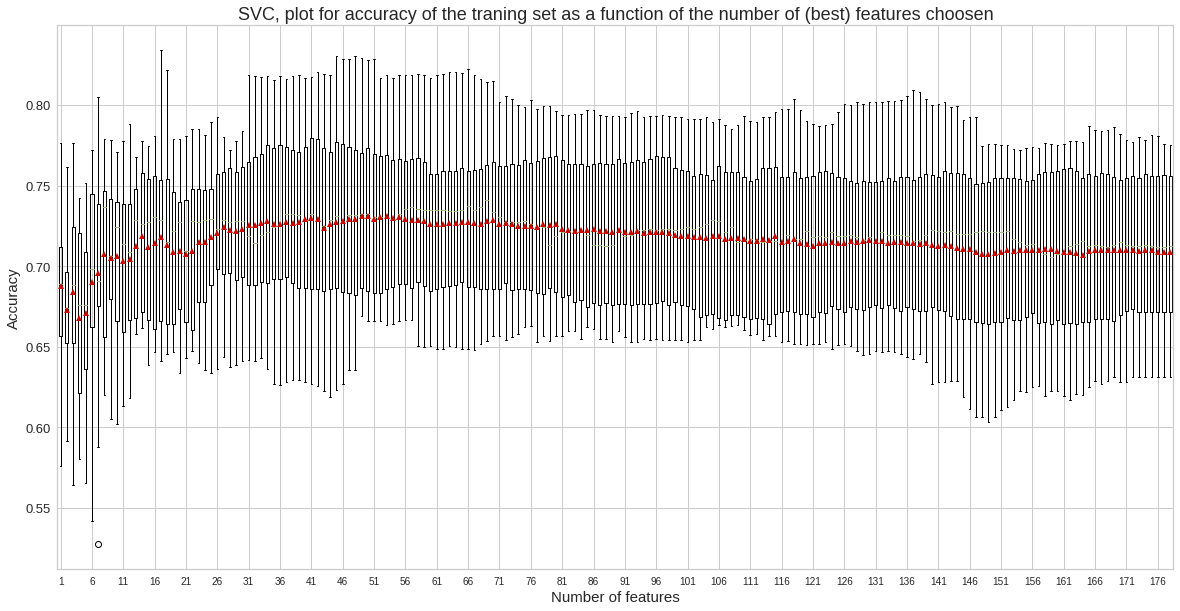

In [230]:
fig, ax = plt.subplots(figsize=(20,10))
plt.boxplot(results, labels=num_features, showmeans=True)
plt.title("SVC, plot for accuracy of the traning set as a function of the number of (best) features choosen", fontsize = 18)
ax.set_xlabel('Number of features', fontsize = 15)
ax.set_ylabel('Accuracy', fontsize = 15)

max_value = max(num_features)
min_value = min(num_features)
number_of_steps = 5
l = np.arange(min_value, max_value+1, number_of_steps)

ax.set(xticks=l, xticklabels=l)

ax.tick_params(axis='y', which='major', labelsize=13)
plt.show()

In [232]:
##### For all models, careful, takes time

grid = dict()
grid['anova__k'] = [i+1 for i in range(X_out_train.shape[1])]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=123)

dict_model_ftest_features_number = {}

for model in models:
    pipeline = Pipeline(steps=[('anova',fs), ('model', model)])
    search = GridSearchCV(pipeline, grid, scoring='roc_auc', n_jobs=-1, cv=cv)
    results = search.fit(X_out_train, y_out_train)
    print("{}:".format(model.__class__.__name__))
    print('Best Mean AUC ROC: %.3f' % results.best_score_)
    print('Best Config: %s' % results.best_params_)
    dict_model_ftest_features_number[model] = results.best_params_

LogisticRegression:
Best Mean AUC ROC: 0.749
Best Config: {'anova__k': 40}
RandomForestClassifier:
Best Mean AUC ROC: 0.741
Best Config: {'anova__k': 168}
SVC:
Best Mean AUC ROC: 0.731
Best Config: {'anova__k': 53}


LogisticRegression(random_state=123)
40
SelectKBest(k=40)
LogisticRegression:
On training we get an Accuracy 0.7774725274725275, an AUC 0.7658878504672897 and F1 score 0.8146453089244852 
For test we get an Accuracy 0.6373626373626373, an AUC 0.6067527308838133 and F1 score 0.7179487179487181


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


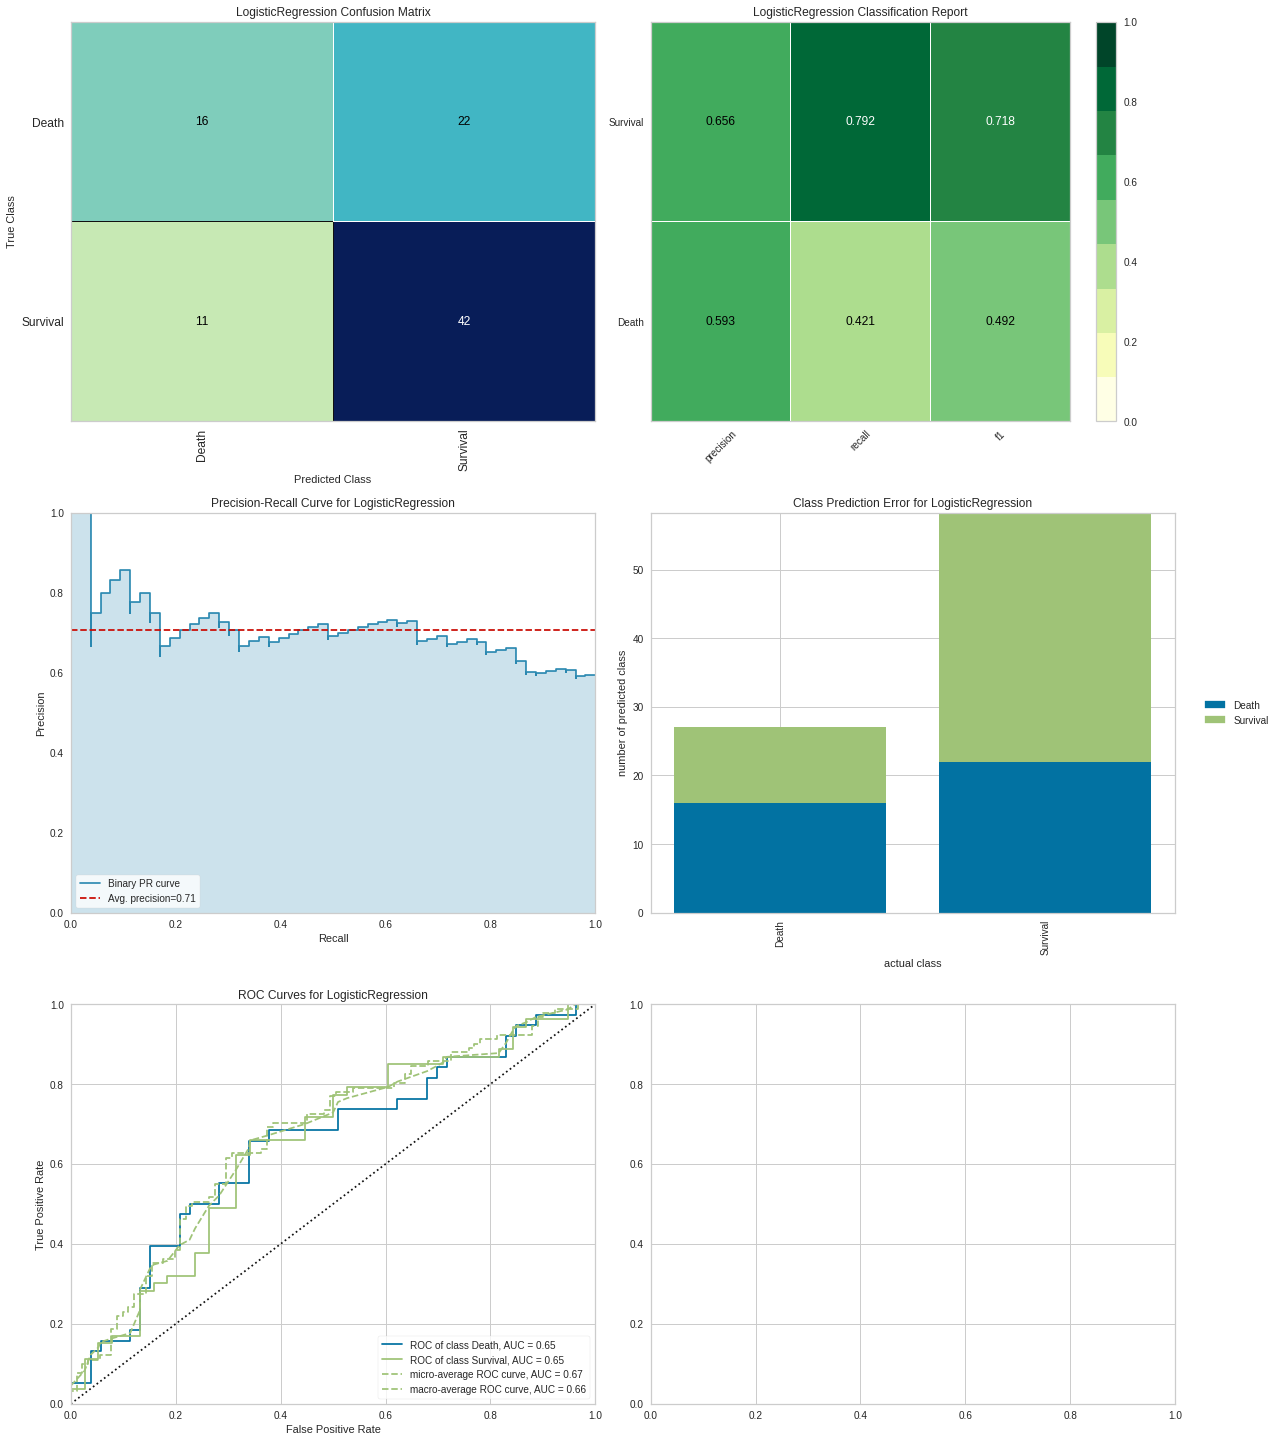

Don't have feature importance


RandomForestClassifier(n_estimators=300, random_state=123)
168
SelectKBest(k=168)
RandomForestClassifier:
On training we get an Accuracy 1.0, an AUC 1.0 and F1 score 1.0 
For test we get an Accuracy 0.6263736263736264, an AUC 0.6010427010923536 and F1 score 0.7017543859649122


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


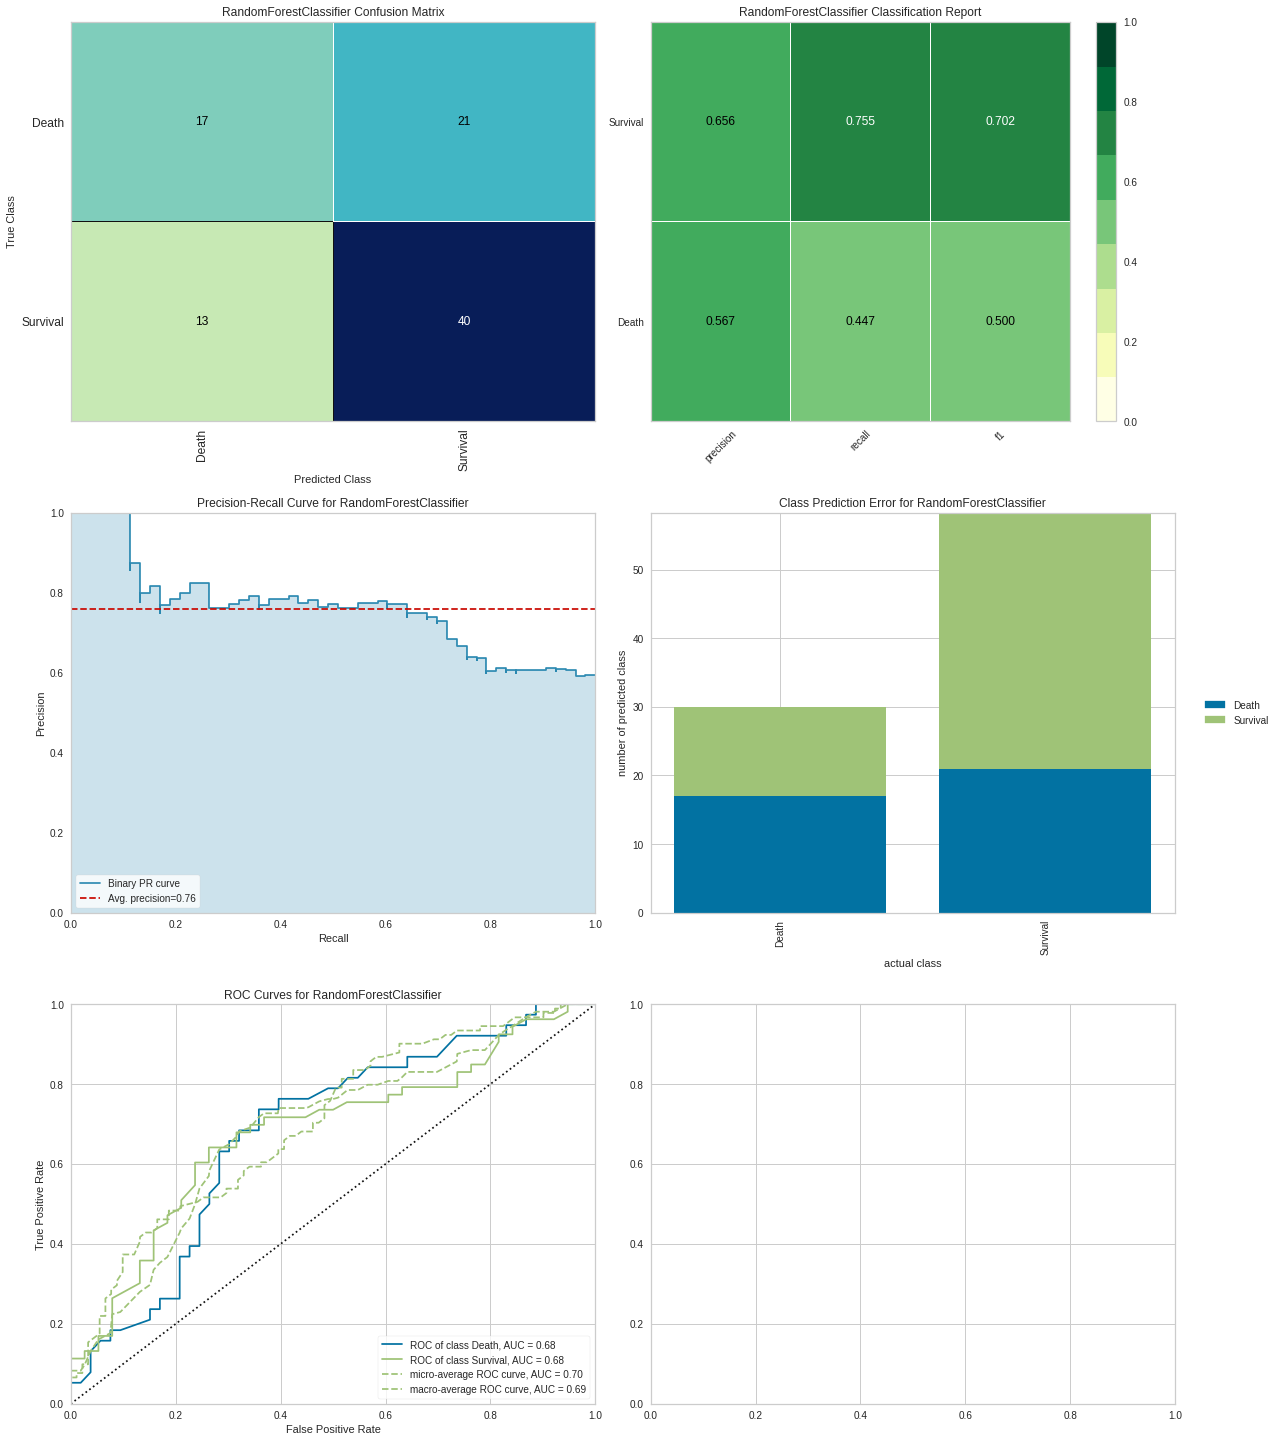

Don't have feature importance


SVC(random_state=123)
53
SelectKBest(k=53)
SVC:
On training we get an Accuracy 0.8626373626373627, an AUC 0.8542679127725856 and F1 score 0.8853211009174311 
For test we get an Accuracy 0.6703296703296703, an AUC 0.6425024826216484 and F1 score 0.7413793103448275


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


Can plot ROC curve for this model
Don't have feature importance


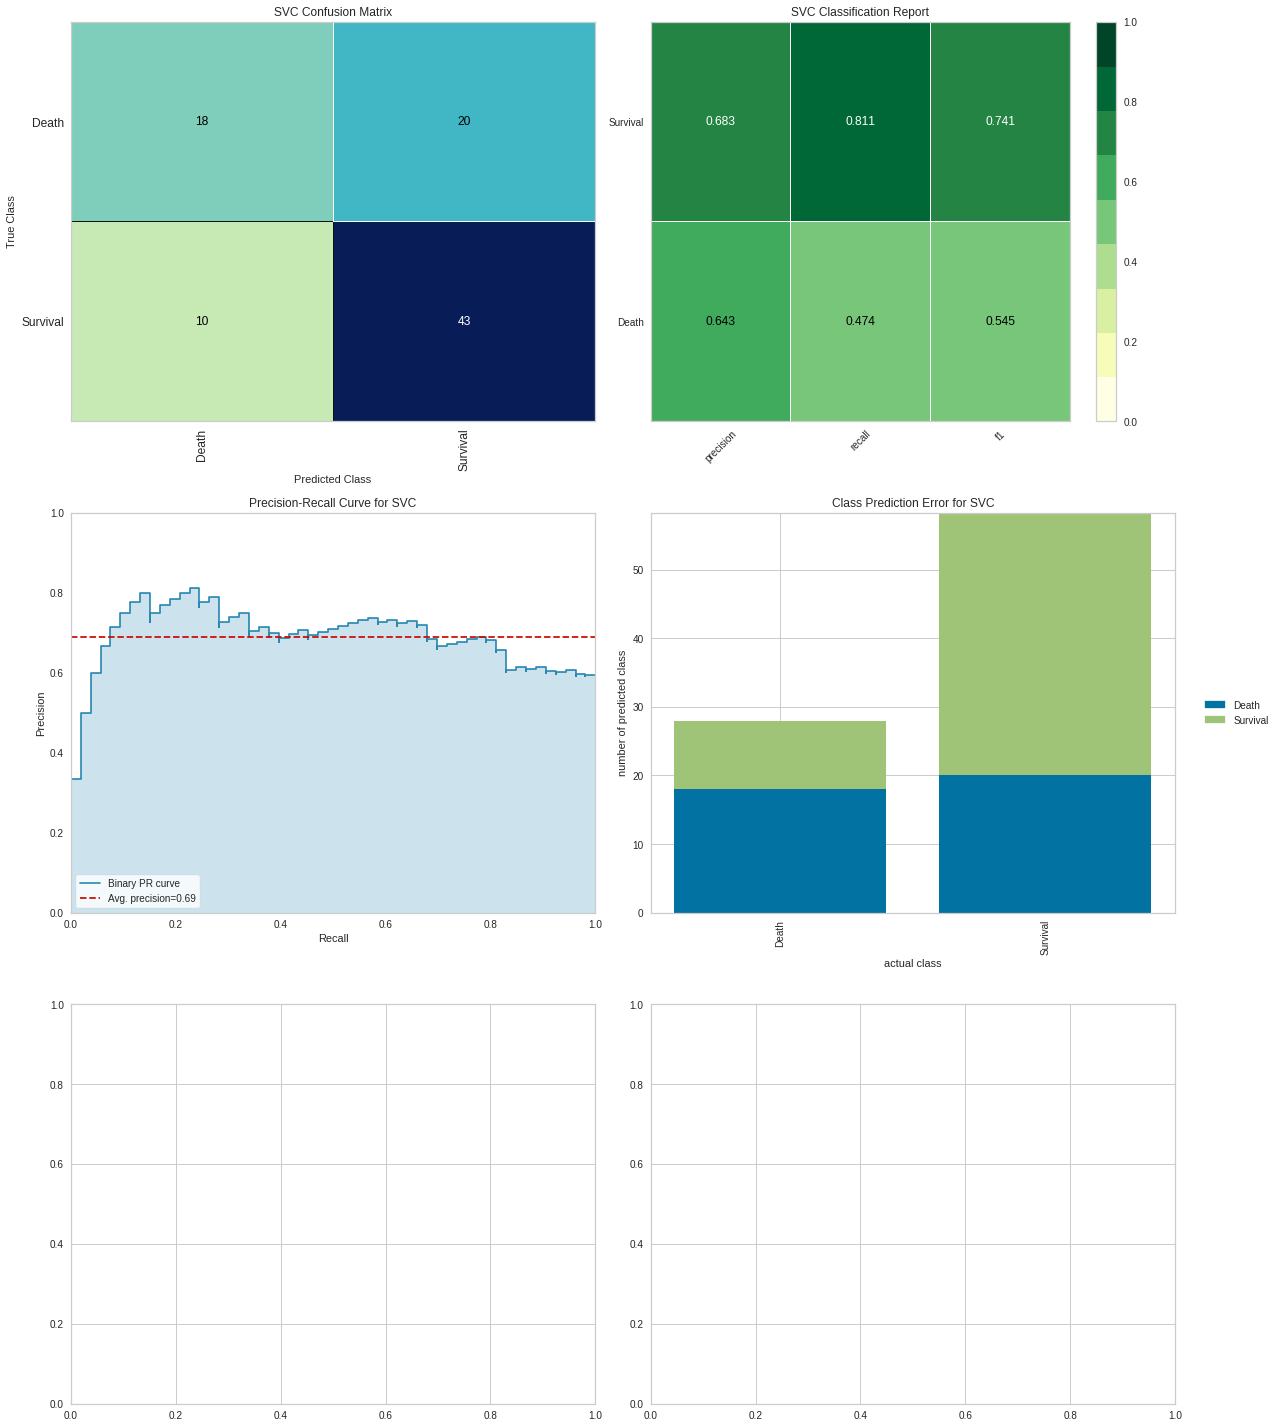

In [233]:
## Print out results for all models

for model in models: 
    print(model)
    print(dict_model_ftest_features_number[model]['anova__k'])
    fs = SelectKBest(score_func=f_classif, k=dict_model_ftest_features_number[model]['anova__k'])
    print(fs)
    X_train_sel_ftest = fs.fit_transform(X_out_train, y_out_train)
    X_test_sel_ftest = fs.transform(X_out_test)
    score_model_outcome(X_train_sel_ftest, y_out_train, X_test_sel_ftest, y_out_test, model)

# Machine Learning Models
## Hyper-tuning and Final Models

*We have now computed the best k for each model, but let us now tune the hype-parameters*

### SVM

/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


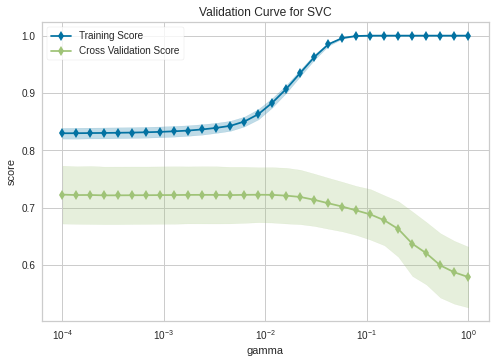

In [236]:
# Validation curve for gamma parameter 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=123)

param_range = np.logspace(-4, 0, 30)

viz = ValidationCurve(SVC(random_state=123), param_name="gamma", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


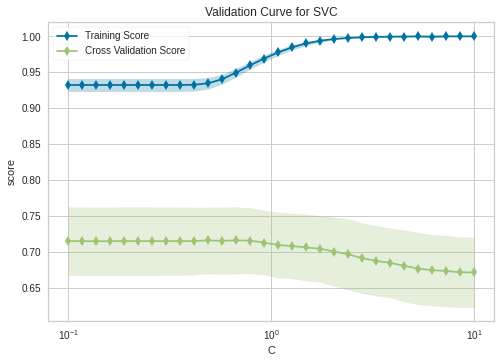

In [237]:
# Validation curve for C parameter 
#cv = StratifiedKFold(n_splits=5, random_state=123)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=123)
param_range = np.logspace(-1, 1, 30)

viz = ValidationCurve(SVC(random_state=123), param_name="C", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

In [263]:
# Found above
best_k = dict_model_ftest_features_number[models[2]]['anova__k']
# Still need to run SVC
# We will run only rbf as we expect it to be the best and otherwise takes too long to run
parameters = {'anova__k': [best_k] ,'model__kernel':['rbf'], 'model__C': np.logspace(-1, 1, 30), 'model__gamma' : np.logspace(-4, 0, 30)}
svc = svm.SVC(random_state=123)


fs = SelectKBest(score_func=f_classif, k= best_k)
print(fs)
pipeline = Pipeline(steps=[('anova',fs), ('model', svc)])

## Find scores and best parameters 
fit_best = fs.fit(X_out_train,y_out_train) # Keep for later plots

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=123)

clf = GridSearchCV(pipeline, parameters, scoring = 'roc_auc', n_jobs=-1, cv = cv)

clf.fit(X_out_train, y_out_train)

SelectKBest(k=53)


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=123),
             estimator=Pipeline(steps=[('anova', SelectKBest(k=53)),
                                       ('model', SVC(random_state=123))]),
             n_jobs=-1,
             param_grid={'anova__k': [53],
                         'model__C': array([ 0.1       ,  0.11721023,  0.13738238,  0.1610262 ,  0.18873918,
        0.22122163,  0.25929438,  0.30391954,  0.35622479,  0.41753189,
        0.48939009,  0.57361525,  0...
       1.26896100e-03, 1.74332882e-03, 2.39502662e-03, 3.29034456e-03,
       4.52035366e-03, 6.21016942e-03, 8.53167852e-03, 1.17210230e-02,
       1.61026203e-02, 2.21221629e-02, 3.03919538e-02, 4.17531894e-02,
       5.73615251e-02, 7.88046282e-02, 1.08263673e-01, 1.48735211e-01,
       2.04335972e-01, 2.80721620e-01, 3.85662042e-01, 5.29831691e-01,
       7.27895384e-01, 1.00000000e+00]),
                         'model__kernel': ['rbf']},
             scoring='roc_auc')

In [264]:
clf.best_score_

0.744028792912514

SVC:
On training we get an Accuracy 0.728021978021978, an AUC 0.7128660436137072 and F1 score 0.7755102040816327 
For test we get an Accuracy 0.6373626373626373, an AUC 0.6104766633565044 and F1 score 0.7130434782608696


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


Can plot ROC curve for this model
Don't have feature importance


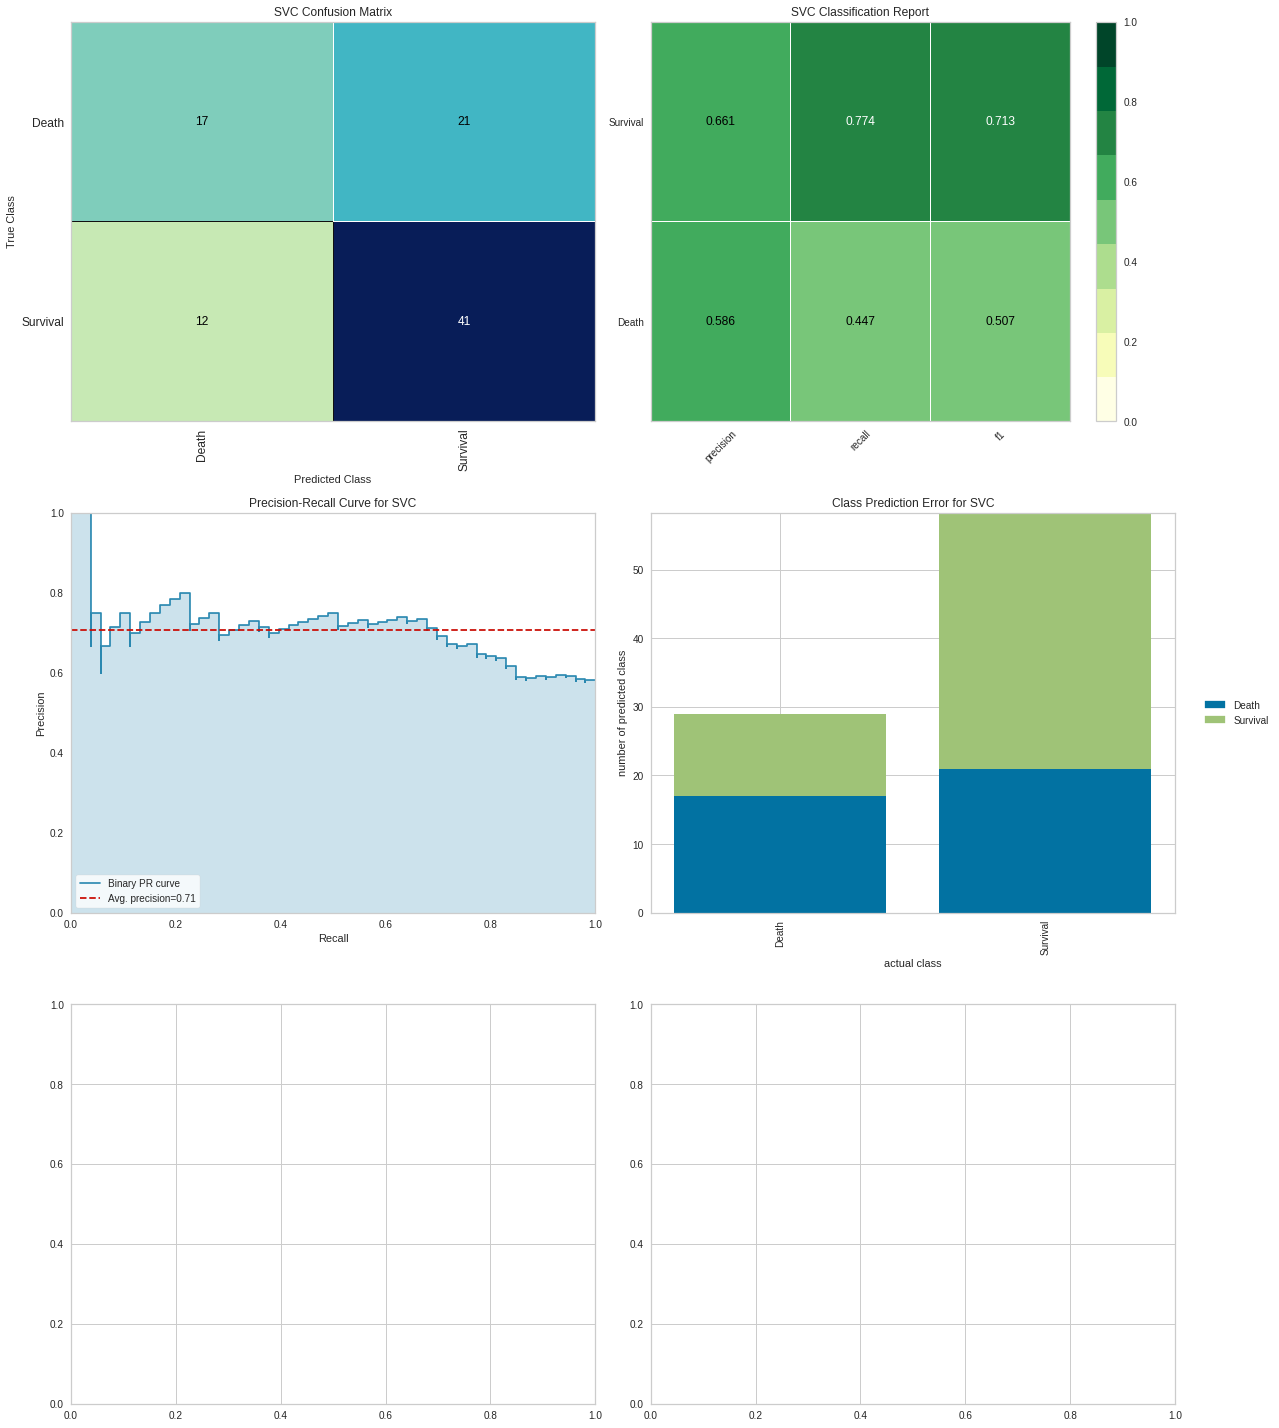

In [265]:
svc = svm.SVC(
    random_state=123,
    C= clf.best_params_['model__C'], 
    gamma = clf.best_params_['model__gamma'], 
    kernel = clf.best_params_['model__kernel']
)


### Add the fs.transform and fs.transform_fit
X_train_sel_ftest = fs.fit_transform(X_out_train, y_out_train)
X_test_sel_ftest = fs.transform(X_out_test)

score_model_outcome(X_train_sel_ftest, y_out_train, X_test_sel_ftest, y_out_test, svc)


##### The most important features are the following

In [244]:
X_out_train.columns[fs.get_support()]

Index(['coartt', 'cefixt', 'multivitt', 'asthen', 'hiccups', 'vertpain',
       'hepmeg', 'photoc', 'desor', 'vomit1', 'diarrc1', 'dyspc1', 'desor1',
       'epista1', 'cefixt2', 'diarrc2', 'ppnt3', 'paracett3', 'cefixt3',
       'multivitt3', 'metaclot3', 'ivcare3', 'rlt3', 'arthralc3', 'anurc3',
       'swallow3', 'vomit3', 'diarrc3', 'dyspc3', 'hepmeg3', 'desor3',
       'injconj3', 'gum3', 'ppnt4', 'orst4', 'paracett4', 'cefixt4',
       'multivitt4', 'ivcare4', 'rlt4', 'asthen4', 'hiccups4', 'anorc4',
       'vomit4', 'diarrc4', 'dyspc4', 'chestpain4', 'deshyd4', 'desor4',
       'epista4', 'gum4', 'hematem4', 'datclin_dayofyear'],
      dtype='object')

In [245]:
#### Scores of most important features
dfscores = pd.DataFrame(fit_best.scores_)

dfcolumns = pd.DataFrame(X_out_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
feat_score_svm = featureScores.nlargest(best_k,'Score')
print(featureScores.nlargest(best_k,'Score'))  

              Features      Score
144            ivcare4  58.082262
145               rlt4  38.399263
107            ivcare3  26.833126
159             dyspc4  23.647131
108               rlt3  21.971224
141            cefixt4  21.375506
120            diarrc3  16.879412
157            diarrc4  15.780380
104            cefixt3  12.638357
122             dyspc3  10.417967
103          paracett3   9.687805
114           swallow3   8.018051
73             cefixt2   7.376931
112          arthralc3   6.657777
167             desor4   6.464830
177  datclin_dayofyear   6.052344
170               gum4   5.897689
86             diarrc2   5.889717
26              photoc   5.830799
133               gum3   5.830799
169            epista4   5.830799
118             vomit3   5.331913
153             anorc4   5.016841
139              orst4   4.938234
51             diarrc1   4.883892
130             desor3   4.498928
4               cefixt   4.425454
61              desor1   4.343351
166           

### Logistic regression

/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


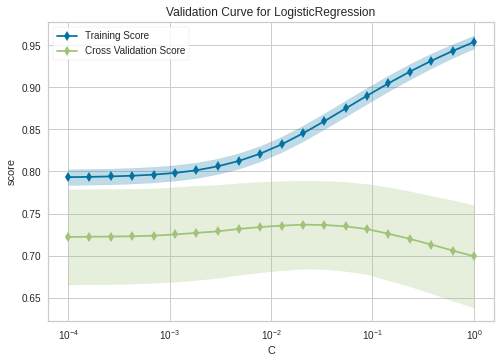

In [258]:
# Validation curve for C parameter 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=123)
param_range = np.logspace(-4, 0, 20)

viz = ValidationCurve(LogisticRegression(random_state=123), param_name="C", param_range=param_range,logx=True, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

In [259]:
# Found above
best_k = dict_model_ftest_features_number[models[0]]['anova__k']

# We will run only rbf as we expect it to be the best and otherwise takes too long to run
parameters = {'anova__k': [best_k] ,'model__penalty': ['l1', 'l2'], 'model__C' : np.logspace(-3, -1, 30)}
logit = LogisticRegression(random_state=123)


fs = SelectKBest(score_func=f_classif, k= best_k)
pipeline = Pipeline(steps=[('anova',fs), ('model', logit)])

## Find scores and best parameters 
fit_best = fs.fit(X_out_train,y_out_train)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=123)

clf = GridSearchCV(pipeline, parameters, scoring = 'roc_auc', n_jobs=-1, cv = cv)

clf.fit(X_out_train, y_out_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=123),
             estimator=Pipeline(steps=[('anova', SelectKBest(k=40)),
                                       ('model',
                                        LogisticRegression(random_state=123))]),
             n_jobs=-1,
             param_grid={'anova__k': [40],
                         'model__C': array([0.001     , 0.0011721 , 0.00137382, 0.00161026, 0.00188739,
       0.00221222, 0.00259294, 0.0030392 , 0.00356225, 0.00417532,
       0.0048939 , 0.00573615, 0.00672336, 0.00788046, 0.00923671,
       0.01082637, 0.01268961, 0.01487352, 0.01743329, 0.0204336 ,
       0.02395027, 0.02807216, 0.03290345, 0.0385662 , 0.04520354,
       0.05298317, 0.06210169, 0.07278954, 0.08531679, 0.1       ]),
                         'model__penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [248]:
clf.best_params_

{'anova__k': 40, 'model__C': 0.1, 'model__penalty': 'l2'}

LogisticRegression:
On training we get an Accuracy 0.739010989010989, an AUC 0.7202180685358255 and F1 score 0.7884187082405346 
For test we get an Accuracy 0.6153846153846154, an AUC 0.5804369414101291 and F1 score 0.7058823529411764


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


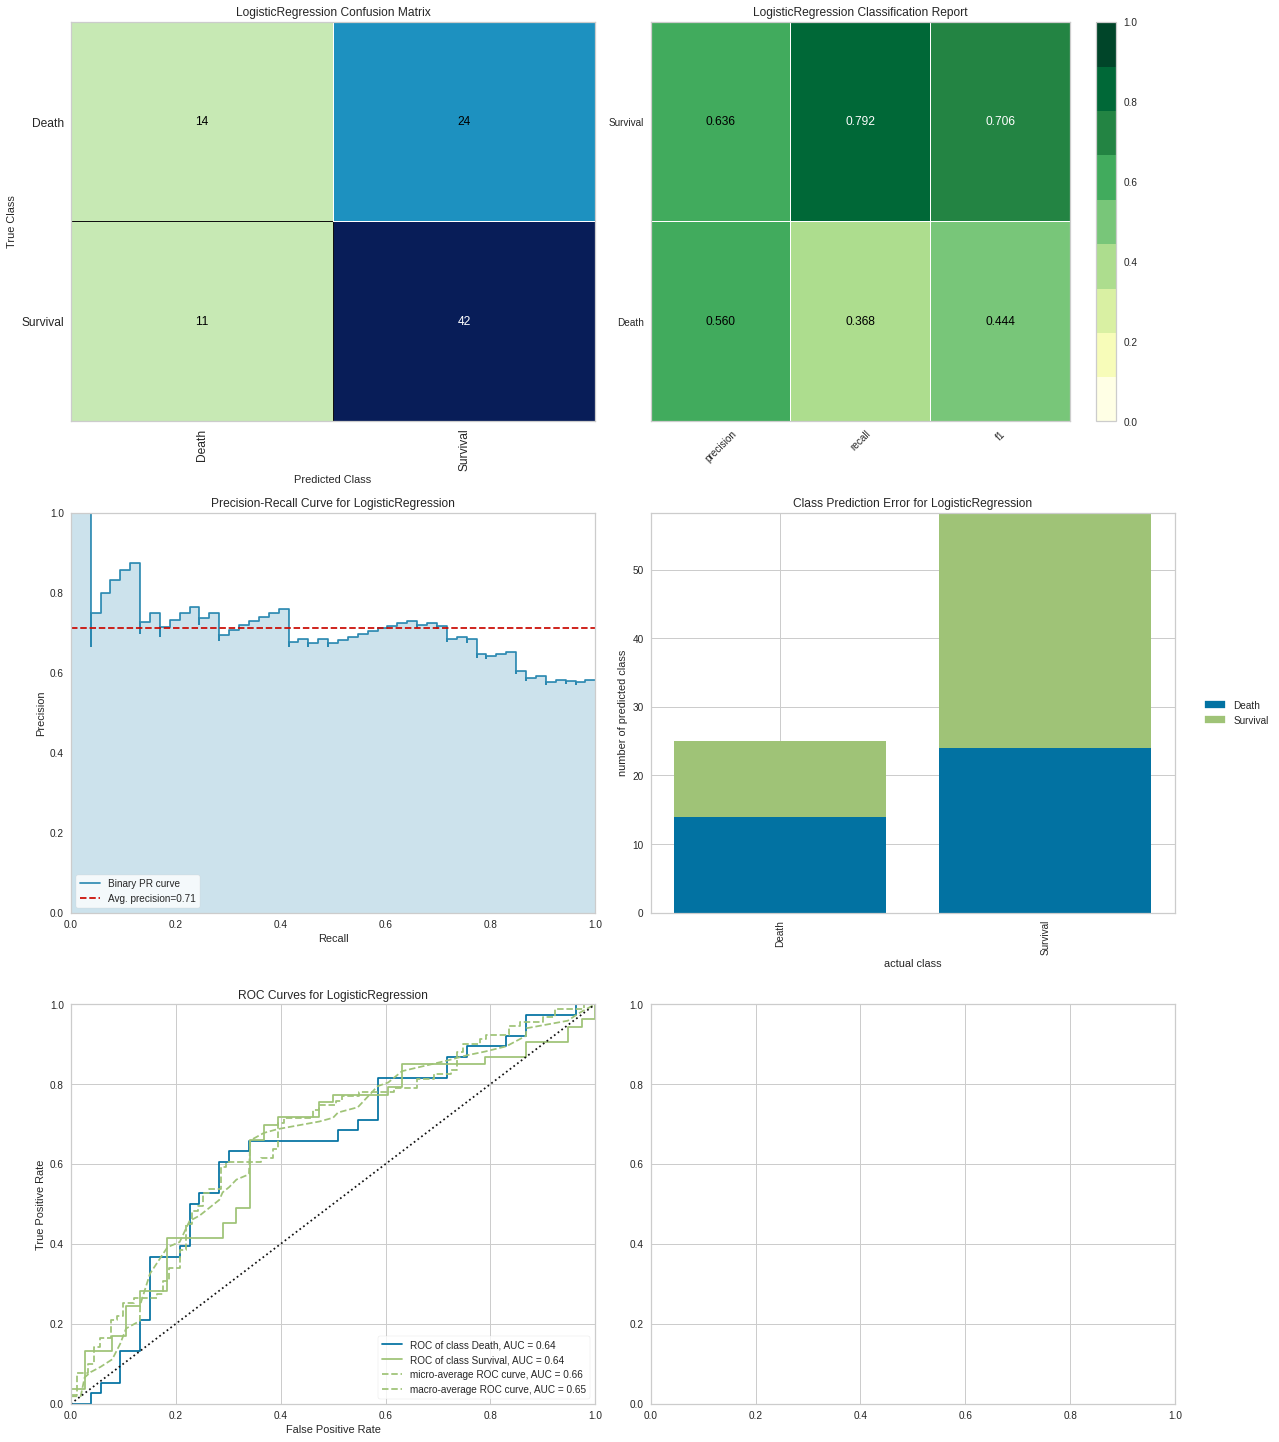

Don't have feature importance




In [249]:
logit = LogisticRegression(
    random_state = 123,
    penalty = clf.best_params_['model__penalty'], 
    C = clf.best_params_['model__C']
)

X_train_sel_ftest = fs.fit_transform(X_out_train, y_out_train)
X_test_sel_ftest = fs.transform(X_out_test)

score_model_outcome(X_train_sel_ftest, y_out_train, X_test_sel_ftest, y_out_test, logit)


##### The most important features are the following

In [250]:
X_out_train.columns[fs.get_support()]

Index(['coartt', 'cefixt', 'asthen', 'hepmeg', 'photoc', 'desor', 'vomit1',
       'diarrc1', 'desor1', 'cefixt2', 'diarrc2', 'paracett3', 'cefixt3',
       'ivcare3', 'rlt3', 'arthralc3', 'anurc3', 'swallow3', 'vomit3',
       'diarrc3', 'dyspc3', 'desor3', 'injconj3', 'gum3', 'ppnt4', 'orst4',
       'paracett4', 'cefixt4', 'multivitt4', 'ivcare4', 'rlt4', 'asthen4',
       'anorc4', 'diarrc4', 'dyspc4', 'deshyd4', 'desor4', 'epista4', 'gum4',
       'datclin_dayofyear'],
      dtype='object')

In [251]:
#### Scores of most important features
dfscores = pd.DataFrame(fit_best.scores_)

dfcolumns = pd.DataFrame(X_out_train.columns)

#concat two dataframes for better visualization 

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns

feat_score_logit = featureScores.nlargest(best_k,'Score')
print(featureScores.nlargest(best_k,'Score'))  

              Features      Score
144            ivcare4  58.082262
145               rlt4  38.399263
107            ivcare3  26.833126
159             dyspc4  23.647131
108               rlt3  21.971224
141            cefixt4  21.375506
120            diarrc3  16.879412
157            diarrc4  15.780380
104            cefixt3  12.638357
122             dyspc3  10.417967
103          paracett3   9.687805
114           swallow3   8.018051
73             cefixt2   7.376931
112          arthralc3   6.657777
167             desor4   6.464830
177  datclin_dayofyear   6.052344
170               gum4   5.897689
86             diarrc2   5.889717
26              photoc   5.830799
133               gum3   5.830799
169            epista4   5.830799
118             vomit3   5.331913
153             anorc4   5.016841
139              orst4   4.938234
51             diarrc1   4.883892
130             desor3   4.498928
4               cefixt   4.425454
61              desor1   4.343351
166           

### Random Forest

Please note that even with repeated stratified K folds we get quite a high variance, we also tried using the important features that were given using a f_classic function to remove all but the highest k scoring features

/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


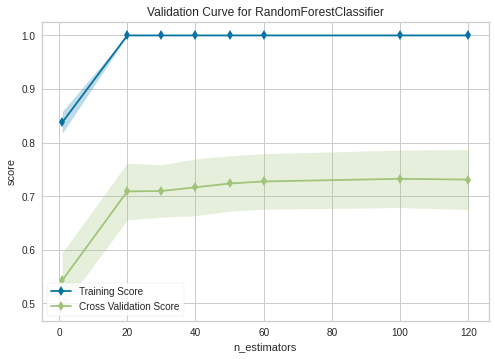

In [252]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=123)
param_range = [1,20,30, 40,50,60,100,120]

viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="n_estimators", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


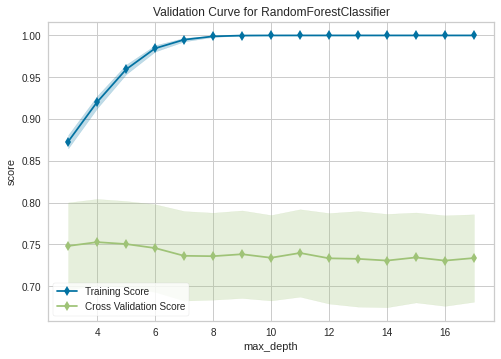

In [253]:
# For max_depth
param_range = np.arange(3,18)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=123)
viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="max_depth", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


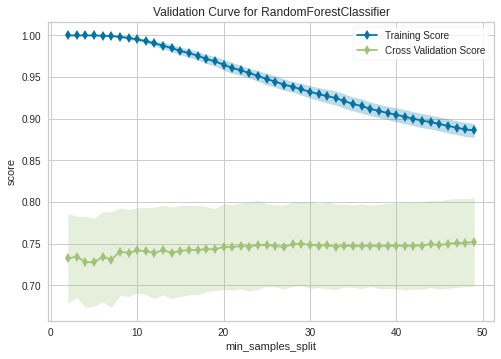

In [254]:
# For min_samples_split

param_range = range(2,50)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=123)
viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="min_samples_split", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()

/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


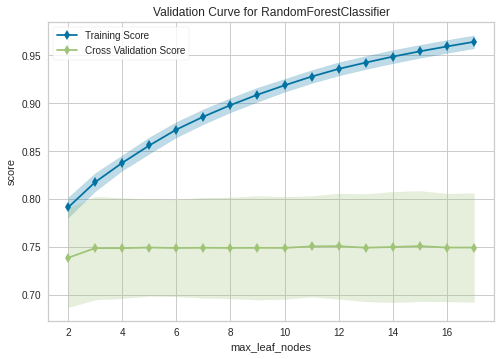

In [255]:
# For max_leaf_nodes
param_range = [2,3,4,5,6, 7, 8, 9, 10,11,12,13,14,15,16,17]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=123)
viz = ValidationCurve(RandomForestClassifier(random_state=123), param_name="max_leaf_nodes", param_range=param_range, cv=cv, scoring="roc_auc", n_jobs=-1)

viz.fit(X_out_train, y_out_train)
viz.show()
plt.show()


In [256]:
# Found above
best_k = dict_model_ftest_features_number[models[1]]['anova__k']

clforest = RandomForestClassifier(random_state = 123)
param_test = {
    'anova__k': [best_k] ,
    'model__n_estimators':[30, 40, 50, 60, 100],
    'model__max_depth':[i for i in range(3, 15)],
    'model__min_samples_split':[i for i in range(2, 5)],
    'model__max_leaf_nodes':[i for i in range(2, 17)]
}

fs = SelectKBest(score_func=f_classif, k= best_k)
print(fs)
pipeline = Pipeline(steps=[('anova',fs), ('model', clforest)])

## Find scores and best parameters 
fit_best = fs.fit(X_out_train,y_out_train)


SelectKBest(k=168)


In [257]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=123)
gsearch = GridSearchCV(estimator= pipeline, param_grid= param_test, scoring='roc_auc', n_jobs=-1, iid=False, cv=cv )
gsearch.fit(X_out_train, y_out_train)
print(gsearch.best_params_)

KeyboardInterrupt: 

In [ ]:
clf_best = RandomForestClassifier(n_estimators=     gsearch.best_params_['model__n_estimators'], 
                                  max_depth=        gsearch.best_params_['model__max_depth'], 
                                  min_samples_split=gsearch.best_params_['model__min_samples_split'],
                                  max_leaf_nodes = gsearch.best_params_['model__max_leaf_nodes'],
                                 random_state = 123)

X_train_sel_ftest = fs.fit_transform(X_out_train, y_out_train)
X_test_sel_ftest = fs.transform(X_out_test)

score_model_outcome(X_train_sel_ftest, y_out_train, X_test_sel_ftest, y_out_test, clf_best)


#### Important features

In [ ]:
X_out_train.columns[fs.get_support()]

In [ ]:
#### Scores of most important features



dfscores = pd.DataFrame(fit_best.scores_)

dfcolumns = pd.DataFrame(X_out_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns

feat_score_RF = featureScores.nlargest(best_k,'Score')

print(featureScores.nlargest(best_k,'Score'))  